# **Importação de Bibliotecas**

In [0]:
#importação das bibliotecas
import os
import numpy as np
import pandas as pd

#bibliotecas para geração de gráficos
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import seaborn as sns

#bibliotecas para machine learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

#biblioteca para nuvens de palavras
from wordcloud import WordCloud

# **Leitura dos Datasets**

In [0]:
#carregamento dos dados
customers = pd.read_csv('/content/drive/My Drive/data/olist_customers_dataset.csv')
products = pd.read_csv('/content/drive/My Drive/data/olist_products_dataset.csv')
order_items = pd.read_csv('/content/drive/My Drive/data/olist_order_items_dataset.csv')
sellers = pd.read_csv('/content/drive/My Drive/data/olist_sellers_dataset.csv')
payments = pd.read_csv('/content/drive/My Drive/data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('/content/drive/My Drive/data/olist_order_reviews_dataset.csv')
orders = pd.read_csv('/content/drive/My Drive/data/olist_orders_dataset.csv')
ibge = pd.read_excel('/content/drive/My Drive/data/dados_ibge_limpo.xlsx')


In [0]:
#cria um dicionário com a os estados de cada região do Brasil para enriquecer os dataset clientes e vendedores
estados = {'sudeste':['SP', 'RJ','MG', 'ES'], 'sul':['RS', 'PR', 'SC'], 'centro-oeste':['DF','GO', 'MT','MS'], 'nordeste':['BA','PE','CE','MA','PB','PI','RN','AL','SE'], 'norte':['PA','TO', 'RO','AM','AC','AP','RR']}
df_regiao = pd.DataFrame.from_dict(estados, orient='index')
df_regiao = df_regiao.transpose().melt(var_name="regiao_cliente", value_name="customer_state")
df_regiao = df_regiao.mask(df_regiao.customer_state.eq('None')).dropna()
df_regiao.reset_index(inplace=True, drop=True)

# **Data wrangling**

##**Etapa 1: Alteração de tipos e preenchimento de alguns campos vazios**

Nessa Primeira etapa vamos apenas realizar o tratamento de campos vazios e alteração de tipo de dados.

### **Dataset Clientes:** 



Não existe valores nulos para os clientes

In [0]:
#informações sobre atributos, tipos de dados
customers.info()
#Conta quantos registros nulos existe no dataset
customers.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Adicionando as regiões do Brasil no dataset

In [0]:
#enriquece o dataframe com os dados da região
customers = pd.merge(customers, df_regiao, left_on="customer_state", right_on="customer_state", how="inner")


In [0]:
#enriquece o dataframe com os dados do ibge
customers = pd.merge(customers, ibge, left_on="customer_state", right_on="UF", how="inner")

In [0]:
len(customers["customer_unique_id"].unique())

96096

### **Dataset Vendedores:** 

O Dataset olist_sellers_dataset não possui valores nulos. 

In [0]:
#informações sobre atributos, tipos de dados
sellers.info()
#Conta quantos registros nulos existe no dataset
sellers.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

In [0]:
#conta quantos vendedores unicos existem
len(sellers["seller_id"].unique())

3095

In [0]:
#renomeia o nome da coluna para diferenciar dos clientes
df_regiao.rename(columns={"regiao_cliente": "regiao_vendedor", "customer_state" : "seller_state"}, inplace=True)
#enriquece o dataframe com os dados da região
sellers = pd.merge(sellers, df_regiao, left_on="seller_state", right_on="seller_state", how="inner")

In [0]:
#enriquece o dataframe com os dados do ibge
sellers = pd.merge(sellers, ibge, left_on="seller_state", right_on="UF", how="inner")

### **Dataset Produtos**: 


Existe 610 registros nulos para os atributos product_category_name, product_name_lenght, product_description_lenght, product_photos_qty e para os atributos product_wight_g, product_length_cm, product_height_cm e product_width_cm existe dois registros em branco. 

Para evitar remover registros da base de dados vamos preencher esses atributos com a média das colunas.

Transforma o tipo da coluna product_category_name em Categoria

In [0]:
#informações sobre tipos 
products.info()
#conta valores nulos
products.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [0]:
#conta quantos vendedores unicos existem
len(products["product_id"].unique())

32951

In [0]:
#Para a coluna categoria as categorias não preenchidas cria uma categoria nova
products['product_category_name'].fillna("nao_classificada", inplace=True)

#Vamos transformar as categorias em tipos categoricos
name_categorias = products['product_category_name'].unique().tolist()
categorias = pd.Categorical(products['product_category_name'], categories=name_categorias)
products['product_category_name'] = categorias


In [0]:
#Preenche os campos vázios com a média dos valores das respectivas colunas
products['product_name_lenght'].fillna((products['product_name_lenght'].mean()), inplace=True)
products['product_description_lenght'].fillna((products['product_description_lenght'].mean()), inplace=True)
products['product_photos_qty'].fillna((products['product_photos_qty'].mean()), inplace=True)
products['product_weight_g'].fillna((products['product_weight_g'].mean()), inplace=True)
products['product_length_cm'].fillna((products['product_length_cm'].mean()), inplace=True)
products['product_height_cm'].fillna((products['product_height_cm'].mean()), inplace=True)
products['product_width_cm'].fillna((products['product_width_cm'].mean()), inplace=True)


### **Dataset de Itens de Venda** 

Primeiro obtemos as informações do dataset. É possível verificar que não existe nenhum registro faltante neste dataset. Após convertemos o atributo shipping_limit_date (data limite de envio) para o tipo Date.

In [0]:
#informações sobre tipos 
order_items.info()
#conta valores nulos
order_items.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [0]:
#converte o tipo do campo data limite de envio para date
order_items['shipping_limit_date'] = pd.to_datetime(order_items['shipping_limit_date'])

In [0]:
#verifica se existe valores duplicados
b = order_items.duplicated(subset=['order_id','order_item_id'])
b.value_counts()

False    112650
dtype: int64

### **Dataset Pagamento**

O Dataset olist_payments_dataset não possui registros faltantes.

In [0]:
#informações sobre tipos 
payments.info()
#conta valores nulos
payments.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [0]:
#verifica se existe valores duplicados
b = payments.duplicated(subset=['order_id','payment_sequential'])
b.value_counts()

False    103886
dtype: int64

### **Dataset Avaliação**

O dataset avaliações (reviews) possui diversos valores em branco para os atributos título e mensagem. A avaliação da compra não é obrigatória, isso justifica os valores ausentes. Para aplicação do modelo de machine learn esses valores não serão um problema. O Score (Pontuação) de todos os pedidos foram preenchidos, vamos utilizar esse atributo no modelo.

A princípio vamos apenas corrigir os tipos de atributos data de criação e data de resposta.

In [0]:
#informações sobre tipos 
reviews.info()
#conta valores nulos
reviews.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


review_id                      0
order_id                       0
review_score                   0
review_comment_title       88285
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [0]:
#verifica se existe valores duplicados
b = reviews.duplicated(subset=['review_id','order_id'])
b.value_counts()

False    100000
dtype: int64

In [0]:
len(reviews["order_id"].unique())

99441

In [0]:
#converte o tipo do campo data limite de envio para date
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'])
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'])

Converte todo o texto para letra minúscula

In [0]:
reviews = reviews.apply(lambda x: x.str.lower() if (x.dtype == "object") else x) 

### **Dataset Pedido**

O Dataset olist_order_dataset possui muitos valores nulos,principalmente no que diz respeito as datas de carregamento da transpostadora e da data de entrega do pedido ao cliente. Alguns registros também não apresentam a data de aprovação do pedido (liberação do pagamento).

Essas valores faltantes podem indicar que um produto ainda não foi entregue, então temos que analisar com atenção antes de realizar o prenchimento desses campos.

In [0]:
#informações sobre tipos 
orders.info()
#conta valores nulos
orders.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [0]:
len(orders["order_id"].unique())

99441

Faz a conversão de tipos object para datetime.

In [0]:
#converte o tipos para campo date
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp']).dt.date
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at']).dt.date
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date']).dt.date
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date']).dt.date
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date']).dt.date


Faz o tratamento de dados faltantes. Alguns registros ainda ficaram em branco, principalmente os relacionados a datas de aprovação, entrega a transportadora e entrega ao cliente, esses registros não podem ser preenchidos, pois sua ausencia indica que uma ação ainda não ocorreu. Quando os dataset forem mesclados (unidos) poderemos optar por remover esses registros.

In [0]:
#faz o preenchimento de campos em branco e algumas correções

#para os pedidos entregues,mas sem data da entrega coloca a data estimada da entrega
orders.loc[(orders["order_status"].eq("delivered") & orders["order_delivered_customer_date"].isna()), "order_delivered_customer_date"] = orders["order_estimated_delivery_date"]

#para os pedidos entregues, mas sem a data de aprovação preenchida, coloque a data da compra
orders.loc[(orders["order_approved_at"].isna() & (orders["order_status"].eq('delivered'))), "order_approved_at"] = orders["order_purchase_timestamp"]

#para os pedidos que não possuem data de entrega ao transportador, mas que foram entregues, calcula a media de dias entre a compra e a entrega ao transportador de todos os pedidos, apos soma-se esses dias a data da compra do pedido que possui o dado faltante
media_dias_transportador = np.mean(orders["order_delivered_carrier_date"] - orders["order_purchase_timestamp"])
orders.loc[(orders["order_delivered_carrier_date"].isna() & (orders["order_status"].eq('delivered'))), "order_delivered_carrier_date"] = orders["order_purchase_timestamp"] + media_dias_transportador

In [0]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 146
order_delivered_carrier_date     1781
order_delivered_customer_date    2957
order_estimated_delivery_date       0
dtype: int64

In [0]:
aux = orders.loc[(orders["order_status"].isin(["canceled", "unavailable"]))]
aux = aux["order_status"].value_counts()    
aux

canceled       625
unavailable    609
Name: order_status, dtype: int64

In [0]:
#remove os pedidos indisponiveis e os cancelados
orders = orders.loc[(~orders["order_status"].isin(["canceled", "unavailable"]))]

In [0]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   5
order_delivered_carrier_date      622
order_delivered_customer_date    1729
order_estimated_delivery_date       0
dtype: int64

In [0]:
#remove os pedidos sem data de ordem de aprovação, provavelmente não foram pagos.
orders = orders.loc[orders["order_approved_at"].notna()]
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date      617
order_delivered_customer_date    1724
order_estimated_delivery_date       0
dtype: int64

In [0]:
#Pega a data do último pedido realizado
ultima_compra = orders["order_purchase_timestamp"].max()

#remove os pedidos que não foram entregues, mas que ainda estão dentro do prazo estimado para entrega
aux = orders.loc[((orders["order_estimated_delivery_date"] > ultima_compra) & orders["order_delivered_customer_date"].isna())]
orders = orders.loc[(~orders["order_id"].isin(aux["order_id"]))]

In [0]:
#verifica quantos registros ausentes ainda existem
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date      617
order_delivered_customer_date    1720
order_estimated_delivery_date       0
dtype: int64

In [0]:
#altera o status dos pedidos que não foram entregues dentro do prazo estabelecido para não entregues
orders["situacao_final"] = orders["order_status"]
orders.loc[(orders["order_approved_at"].isna() | orders["order_delivered_carrier_date"].isna() | orders["order_delivered_customer_date"].isna()), "situacao_final"] = "não entregue"

In [0]:
#orders.loc[orders["order_status"] == "não entregue"]
x = orders["situacao_final"].value_counts()
x

delivered       96478
não entregue     1720
Name: situacao_final, dtype: int64

In [0]:
#pega o número dias que uma entrega mais demorou para ser entregue
maior_tempo_entrega = (orders["order_delivered_customer_date"] - orders["order_estimated_delivery_date"]).max()

#calcula uma data fictícia de entrega para os pedidos não entregues
orders.loc[(orders["situacao_final"].eq("não entregue")), "order_delivered_customer_date"] = orders["order_estimated_delivery_date"]  + maior_tempo_entrega

In [0]:
#para os demais pedidos que não possuem data de entrega ao transportador calcula a media de dias entre a compra e a entrega ao transportador de todos os pedidos, apos soma-se esses dias a data da compra do pedido que possui o dado faltante
media_dias_transportador = np.mean(orders["order_delivered_carrier_date"] - orders["order_purchase_timestamp"])
orders.loc[(orders["order_delivered_carrier_date"].isna()), "order_delivered_carrier_date"] = orders["order_purchase_timestamp"] + media_dias_transportador


In [0]:
#cria a coluna tempo tempo de entrega (dias)
orders = orders.assign(tempo_de_entrega= (orders["order_delivered_customer_date"]) - (orders["order_purchase_timestamp"]))

#cria a coluna tempo prazo entrega (dias)
orders = orders.assign(prazo_de_entrega= (orders["order_estimated_delivery_date"]) - (orders["order_purchase_timestamp"]))

#cria a coluna diferença entre tempo previsto e tempo de entrega real 
orders = orders.assign(diff_entrega_prazo= (orders["tempo_de_entrega"]) - (orders["prazo_de_entrega"]))

In [0]:
orders.isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
situacao_final                   0
tempo_de_entrega                 0
prazo_de_entrega                 0
diff_entrega_prazo               0
dtype: int64

Transforma em categoria o status

In [0]:
#os tipos das colunas são todos objetos, devemos converte o statuso para categoria, e as data para date
name_status = orders["order_status"].unique().tolist();
categorias = pd.Categorical(orders["order_status"], categories=name_status)
orders['order_status'] = categorias

#os tipos das colunas são todos objetos, devemos converte o statuso para categoria, e as data para date
name_status = orders["situacao_final"].unique().tolist();
categorias = pd.Categorical(orders["situacao_final"], categories=name_status)
orders['situacao_final'] = categorias

In [0]:
#uma opção para facilitar todo esse trabalho seria excluir os registros que nao possuem data de entrega
#orders = orders.loc[(orders["order_delivered_customer_date"].notna())]

In [0]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98198 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   order_id                       98198 non-null  object         
 1   customer_id                    98198 non-null  object         
 2   order_status                   98198 non-null  category       
 3   order_purchase_timestamp       98198 non-null  object         
 4   order_approved_at              98198 non-null  object         
 5   order_delivered_carrier_date   98198 non-null  object         
 6   order_delivered_customer_date  98198 non-null  object         
 7   order_estimated_delivery_date  98198 non-null  object         
 8   situacao_final                 98198 non-null  category       
 9   tempo_de_entrega               98198 non-null  timedelta64[ns]
 10  prazo_de_entrega               98198 non-null  timedelta64[ns]
 11  di

order_id  ... diff_entrega_prazo
0  e481f51cbdc54678b7cc49136f2d6af7  ...            -8 days
1  53cdb2fc8bc7dce0b6741e2150273451  ...            -6 days
2  47770eb9100c2d0c44946d9cf07ec65d  ...           -18 days
3  949d5b44dbf5de918fe9c16f97b45f8a  ...           -13 days
4  ad21c59c0840e6cb83a9ceb5573f8159  ...           -10 days

[5 rows x 12 columns]

##**Etapa 2: Estatísticas básicas**

### **Dataset Clientes:** 

Não existe dados númericos no dataset cliente.

In [0]:
customers.info()
#apresenta as estatísticas básicas sobre o dataset
customers.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 17 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   customer_id                         99441 non-null  object 
 1   customer_unique_id                  99441 non-null  object 
 2   customer_zip_code_prefix            99441 non-null  int64  
 3   customer_city                       99441 non-null  object 
 4   customer_state                      99441 non-null  object 
 5   regiao_cliente                      99441 non-null  object 
 6   Estado                              99441 non-null  object 
 7   UF                                  99441 non-null  object 
 8   area_territorial_km2_ 2018          99441 non-null  float64
 9   populacao_estimada_2019             99441 non-null  int64  
 10  densidade_demografica_2010          99441 non-null  float64
 11  matriculas_ensino fundamental_2018  99441

customer_zip_code_prefix  ...  total_veiculos_2018
count              99441.000000  ...         9.944100e+04
mean               35137.474583  ...         1.582446e+07
std                29797.938996  ...         1.151797e+07
min                 1003.000000  ...         1.950390e+05
25%                11347.000000  ...         6.725822e+06
50%                24416.000000  ...         1.119134e+07
75%                58900.000000  ...         2.905775e+07
max                99990.000000  ...         2.905775e+07

[8 rows x 10 columns]

### **Dataset Vendedores:** 

Não existe dados númericos no dataset cliente.

In [0]:
sellers.info()
#apresenta as estatísticas básicas sobre o dataset
sellers.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3095 entries, 0 to 3094
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   seller_id                           3095 non-null   object 
 1   seller_zip_code_prefix              3095 non-null   int64  
 2   seller_city                         3095 non-null   object 
 3   seller_state                        3095 non-null   object 
 4   regiao_vendedor                     3095 non-null   object 
 5   Estado                              3095 non-null   object 
 6   UF                                  3095 non-null   object 
 7   area_territorial_km2_ 2018          3095 non-null   float64
 8   populacao_estimada_2019             3095 non-null   int64  
 9   densidade_demografica_2010          3095 non-null   float64
 10  matriculas_ensino fundamental_2018  3095 non-null   int64  
 11  idh_2010                            3095 no

seller_zip_code_prefix  ...  total_veiculos_2018
count             3095.000000  ...         3.095000e+03
mean             32291.059451  ...         2.022131e+07
std              32713.453830  ...         1.088903e+07
min               1001.000000  ...         2.778310e+05
25%               7093.500000  ...         7.571122e+06
50%              14940.000000  ...         2.905775e+07
75%              64552.500000  ...         2.905775e+07
max              99730.000000  ...         2.905775e+07

[8 rows x 10 columns]

### **Dataset Produtos**: 

As estatísticas básicas apresentam indicadores de que existe alguns outliers no dataset produto. Para visualizar melhor os possíveis outliers vamos gerar os graficos de caixas "boxplot".

In [0]:
#apresenta as estatísticas básicas sobre o dataset
products.describe()

product_name_lenght  ...  product_width_cm
count         32951.000000  ...      32951.000000
mean             48.476949  ...         23.196728
std              10.150458  ...         12.078681
min               5.000000  ...          6.000000
25%              42.000000  ...         15.000000
50%              51.000000  ...         20.000000
75%              57.000000  ...         30.000000
max              76.000000  ...        118.000000

[8 rows x 7 columns]

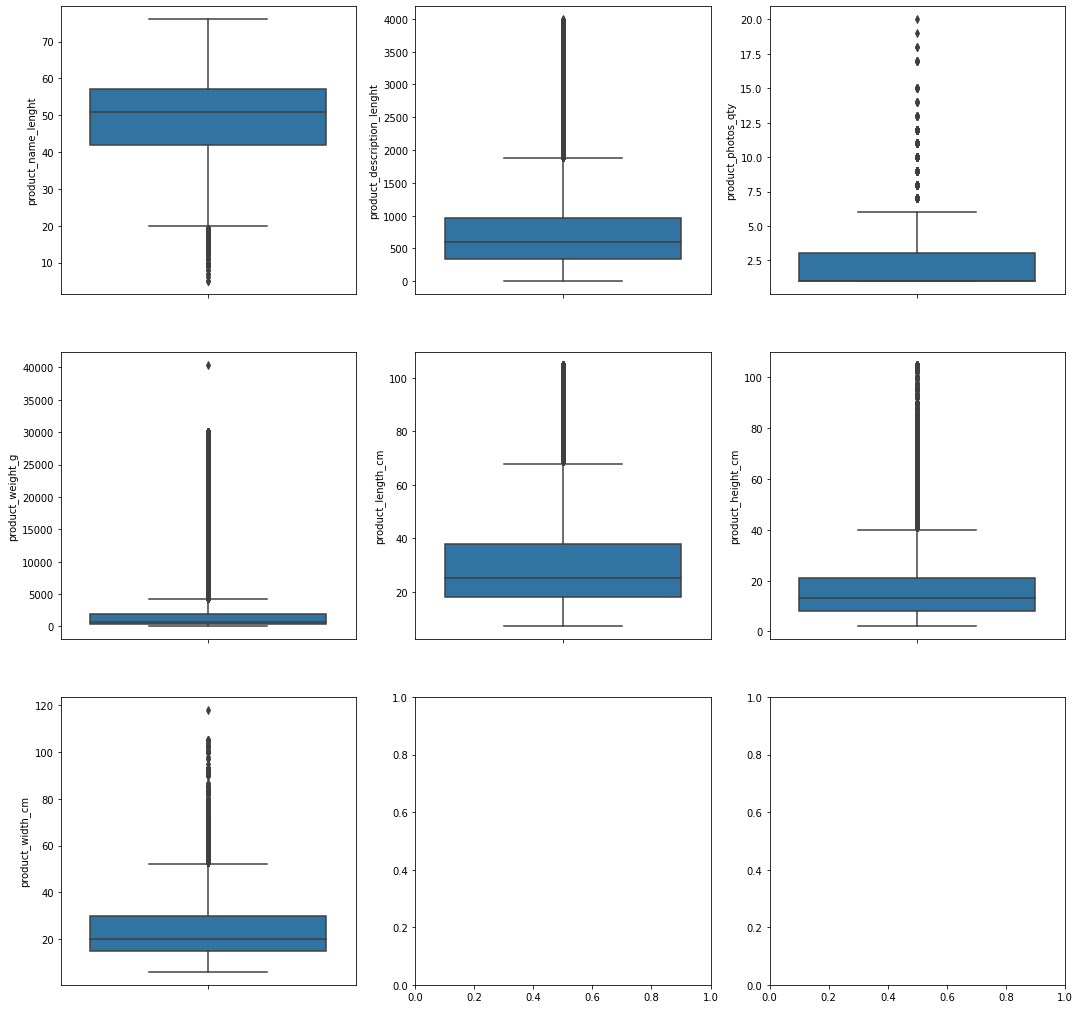

In [0]:
#as estatísticas básicas apresentaram que existe outliers na amostra, vamos analisar com o boxblot
#gera o gráfico de boxplot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 18))
i = 0; j = 0
for c in products.select_dtypes(include='float64').columns:  
  sns.boxplot(y=products[c],  ax=axes[i][j])
  if (j < 2):    
    j = j + 1
  elif (i == 0):
    j = 0; i = 1
  else: 
    j = 0; i = 2
plt.show()

Pelo diagrama de boxplot todos os atributos apresetam valores de outlier em grande quantidade. As variáveis nome, descrição e fotos apesar de mostrarem diversos outliers, podemos entender que se tratam de outliers naturais, que não foram causados por erros, não podemos realizar tratamentos nelas, pois elas represetam os produtos como foram cadastrados, alguns com mais detalhes que outro.

Quantos as variáveis largura, altura, profundidade e peso é dificil analisas em separado, apesar do boxplot mostrar outliers não é possível concluir que realmente estamos observando outliers olhando as variaveis separadamentes. 

Para verificar a existência desses outliers vamos reduzir as variáveis altura, largura e profundidade para uma única variável chamada volume, após vamos comparar o volume em relação ao peso do produto. Para isso vamos plotar um gráfico de dispersão, espera-se que o peso do produto esteja associado ao seu volume e produtos, e pontos muito dispersos no gráfico indiquem a existência de outliers.


Text(0.5, 1.0, 'Relação peso x volume')

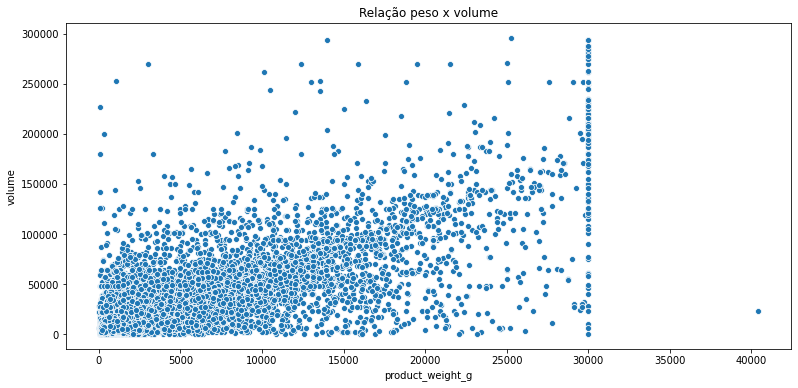

In [0]:
#adiciona a coluna volume do dataset
products = products.assign(volume = products["product_length_cm"] * products["product_height_cm"] * products["product_width_cm"])
#cria um gráfico de dispersão em relação ao peso e o frete dos produtos
plt.figure(figsize=(13, 6))
sns.scatterplot(x="product_weight_g", y="volume", data=products).set_title("Relação peso x volume")

O Gráfico de dispersão apresenta um ponto muito distante, um produto com aproximadamente 40kg e volume de 0,04m<sup>3</sup>), vamos alterar o valor do peso desse produto pela media dos produtos.

In [0]:

#existe um produto com 40kg, sendo que a 75% o peso máximo é de 1.9kg, vamos olhar as dimensões do produto e verificar se o valor do frete corresponde ao peso do produto ou se ocorreu um erro de digitação
produto_peso_suspeito = products.loc[(products["product_weight_g"] == products["product_weight_g"].max())]
produto_peso_suspeito.head()
#as dimensões do produto parecem ser pequenas, vamos analisar o valor do frete
item_peso_suspeito = order_items.loc[order_items["product_id"].isin(produto_peso_suspeito["product_id"])]
item_peso_suspeito.head()

#O valor do frete do produto é apenas R$ 12,06 e 16,32, considerando as dimensões e o valor do frete, bem com a categoria do produtos"cama_mesa_banho" 
#entendemos que houve um erro de digitação,vamos corrigir esse valor pela media dos pesos da categoria
#Alterar o peso do maior produto (outlier) para 0 temporariamente
products.loc[(products["product_weight_g"] == products["product_weight_g"].max()), "product_weight_g"] = 0

#seleciona todos os produtos da categoria cama_mesa_banho
produtos_mesma_categoria = products.loc[(products["product_category_name"] == produto_peso_suspeito["product_category_name"].values[0])]

#atualiza os produtos com valor 0, colocando a media dos valores da categoria: obs: existe outros produtos com peso 0,mas são da mesma categoria (cama, mesa e banho)
products.loc[(products["product_weight_g"] == 0), "product_weight_g"] = produtos_mesma_categoria["product_weight_g"].mean()

Text(0.5, 1.0, 'Relação peso x volume')

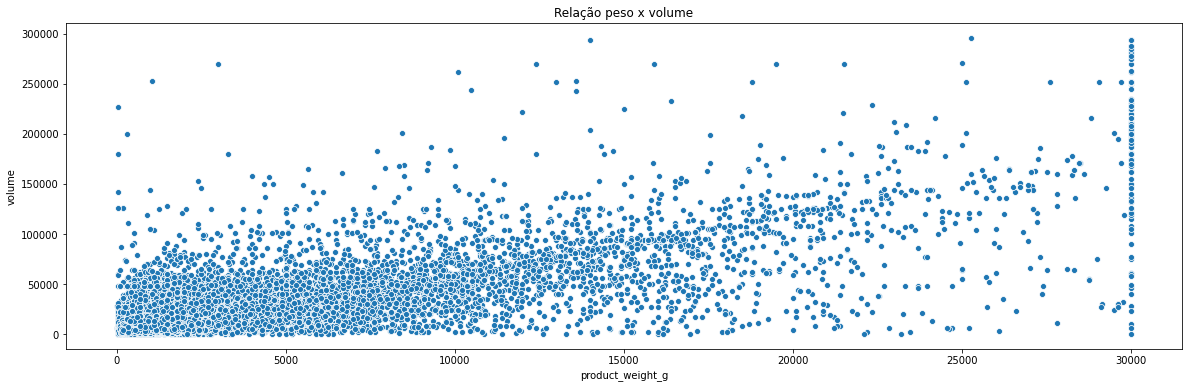

In [0]:
#cria um gráfico de dispersão em relação ao peso e o frete dos produtos
plt.figure(figsize=(20, 6))
sns.scatterplot(x="product_weight_g", y="volume", data=products).set_title("Relação peso x volume")

### **Dataset Itens do Pedido**: 

Apresenta as estatísticas básicas do dataset itens pedidos. A variável valor do frete possui valores com 0 que representa frete grátis,o maior valor de frete é 409,68 que aparentemente parecer estar correto. Geralmente o frete tende a ser mais barato do que o valor do produto. Vamos comprovar isso por meio de um gráfico de dispersão.

In [0]:
#apresenta as estatísticas básicas sobre o dataset
order_items.describe()

order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000

Text(0.5, 1.0, 'Relação frete vs valor do produto')

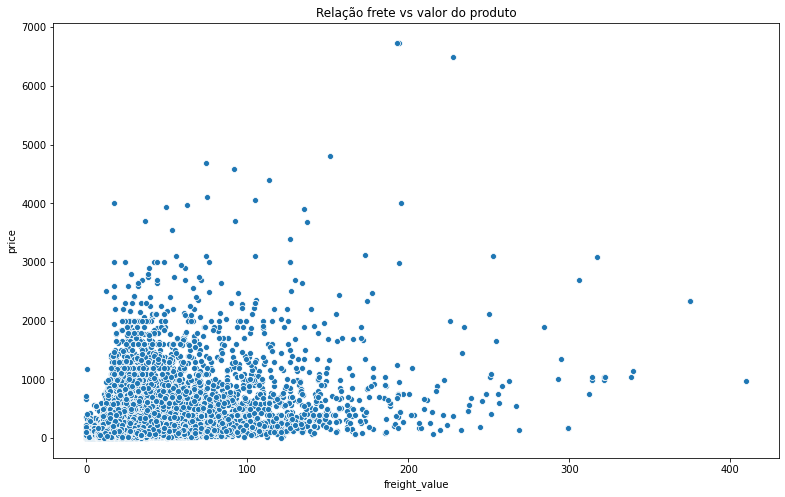

In [0]:
plt.figure(figsize=(13, 8))
sns.scatterplot(x="freight_value", y="price", data=order_items).set_title("Relação frete vs valor do produto")

### **Dataset Pagamento**: 

O dataset pagamento possui número de parcelas igual a 0 e o valor do pagamento igual a 0. Vamos olhar quais são esses registros.

In [0]:
#mostra as estatisticas básica sobre o dataset
payments.describe()
#filtra os pagamentos que possuem 0 parcelas ou 0 valor
payments_0 = payments[((payments["payment_installments"] == 0) | (payments["payment_value"] == 0))]
#faz a junção com os pedidos
payments_0 = pd.merge(payments_0, orders, on="order_id", how="inner")
payments_0

order_id  ...  diff_entrega_prazo
0  8bcbe01d44d147f901cd3192671144db  ...            -19 days
1  fa65dad1b0e818e3ccc5cb0e39231352  ...            188 days
2  fa65dad1b0e818e3ccc5cb0e39231352  ...            188 days
3  6ccb433e00daae1283ccc956189c82ae  ...            -14 days
4  744bade1fcf9ff3f31d860ace076d422  ...            -19 days
5  45ed6e85398a87c253db47c2d9f48216  ...            -18 days
6  1a57108394169c0b47d8f876acc9ba2d  ...            -13 days
7  b23878b3e8eb4d25a158f57d96331b18  ...            -22 days

[8 rows x 16 columns]

 Analisando o dataset em conjunto com o dataset pedidos observamos que os pagamentos com valor 0 foram realizados com o tipo de pagamento voucher, uma especie de credito, por isso não a valor cobrado. Existe duas compras com número de parcelas 0, que foram pagas com cartão de credito e foram entregues. Vamos alterar o valor 0 para 1 parcela. 

In [0]:
payments.loc[(payments["payment_installments"] == 0), "payment_installments"] = 1


As compras com tipo de pagamento não definido foram canceladas. Vamos apagar esses pagamentos,a final não foram realizados.

In [0]:
#faz a junção de pagamentos e de pedidos
payments_order = pd.merge(payments, orders, on="order_id", how="inner")
payments_not_defined = payments_order.loc[payments_order["payment_type"] == "not_defined"]
payments_not_defined.head()

Empty DataFrame
Columns: [order_id, payment_sequential, payment_type, payment_installments, payment_value, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date, situacao_final, tempo_de_entrega, prazo_de_entrega, diff_entrega_prazo]
Index: []

In [0]:
#apaga as colunas com pagamento não definido
payments = payments.loc[payments["payment_type"] != "not_defined"]


### **Dataset Avaliação**

O dataset avaliação parece estar ok.

In [0]:
reviews.describe()

review_score
count  100000.000000
mean        4.070890
std         1.359663
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000

### **Dataset Pedidos**

O dataset pedido não possui valores quantitativos.

In [0]:
orders.describe()

tempo_de_entrega  ...        diff_entrega_prazo
count                    98198  ...                     98198
mean   16 days 00:56:43.279089  ...  -9 days +15:01:29.085317
std    28 days 04:48:47.196447  ...   28 days 02:17:38.537572
min            0 days 00:00:00  ...       -147 days +00:00:00
25%            7 days 00:00:00  ...        -17 days +00:00:00
50%           10 days 00:00:00  ...        -12 days +00:00:00
75%           16 days 00:00:00  ...         -7 days +00:00:00
max          333 days 00:00:00  ...         188 days 00:00:00

[8 rows x 3 columns]

##**Etapa 3: Junção dos Datasets**

Antes de realizar a junção dos dataset, entrei algumas inconsistências entre a data de compra e a data da avaliação do cliente. Encontrei pedido que foi realizado em 2018-09-03 e foi criada uma avaliação negativa (score 1) para ele com  anterior a data da compra 2018-08-31, conforme mostrado abaixo. Abaixo analiso se existe mais inconsistência e realizo a remoção desses registros.

In [0]:
df_aux = pd.merge(orders, reviews, on="order_id", how="inner")
#existe 61 registros onde a data de compra e superior, realizada depois, da data de avaliacao
df_aux = df_aux.loc[(df_aux["order_purchase_timestamp"] > df_aux["review_answer_timestamp"].dt.date)]

#nao existe registro onde a data de compra foi realizada apos a data de aprovação
#df_aux = df_aux.loc[(df_aux["order_purchase_timestamp"].dt.date > df_aux["order_approved_at"].dt.date)]

#nao existe registro onde a data de compra foi realizada apos a data da entrega
#df_aux = df_aux.loc[(df_aux["order_purchase_timestamp"].dt.date > df_aux["order_delivered_customer_date"].dt.date)]

#existe 38 registros cuja a data de aprovação foi realizada após a data da entrega, mas eles já estão dentro dos que a avaliação ocorreu 
#df_aux = df_aux.loc[(df_aux["order_approved_at"].dt.date > df_aux["order_delivered_customer_date"].dt.date)]

#apagas os registros inconsistentes
orders = orders.loc[~(orders["order_id"].isin(df_aux["order_id"]))]
reviews = reviews.loc[~(reviews["order_id"].isin(df_aux["order_id"]))]

Vamos realizar a junção de todos dataset isso será útil mais a frete

In [0]:
#df_basico é a junção dos datasets pedidos, itens pedido,clientes e vendedores e produtos
df_basico = pd.merge(orders, customers, on="customer_id",how="inner")
df_basico = pd.merge(df_basico, order_items, on="order_id", how="inner")
df_basico = pd.merge(df_basico, sellers,on="seller_id", how="inner")
df_basico = pd.merge(df_basico, products,on="product_id", how="inner")

#dfb_reviews é a junção do df básico mais o dataset reviews * isso porque existe mais de uma avaliação para um pedido
dfb_reviews = pd.merge(df_basico, reviews, on="order_id", how="inner")

#dfb_payments é a junção do df básico mais o dataset payments * isso porque existe mais de um pagamento para um pedido
dfb_payments = pd.merge(df_basico, payments, on="order_id", how="inner")

#df total é a junção de todos os datasets
df_total = pd.merge(dfb_payments, reviews, on="order_id", how="inner")

print(df_basico.shape[0])
print(dfb_reviews.shape[0])
print(dfb_payments.shape[0])
print(df_total.shape[0])

112091
112756
117018
117725


# **Data Visualização**

Vamos realizar algumas visualizações sobre os datasets

### **Dataset Clientes:** 

A maior parte dos clientes estão da região Sudeste, sendo São Paulo o estado que possui mais clientes. A região norte é a região de possui menos clientes.

Text(0.5, 1.0, 'Quantidade de Compradores por Região')

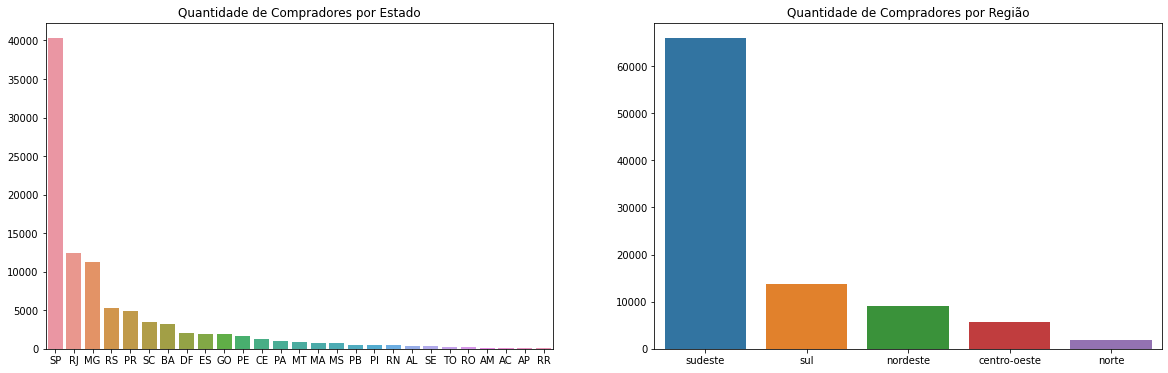

In [0]:
#recupera apenas os clientes únicos
clientes= customers.drop_duplicates(subset='customer_unique_id')

#conta quantos clientes existe por estado e por região
quant_clientes_estados = clientes['customer_state'].value_counts()
quant_clientes_regiao = clientes['regiao_cliente'].value_counts()

#imprime um gráfico de colunas com a quantidade de clientes por estado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x=quant_clientes_estados.index, y=quant_clientes_estados.values, ax=axes[0]).set_title("Quantidade de Compradores por Estado")
sns.barplot(x=quant_clientes_regiao.index, y=quant_clientes_regiao.values, ax=axes[1]).set_title("Quantidade de Compradores por Região")

O Valor gasto em compras,desconsiderando o valor do frete por pelos clientes e cada estado é proporcional a quantidade de clientes de cada estado. 

Text(0.5, 1.0, 'Valor gasto por clientes no estado')

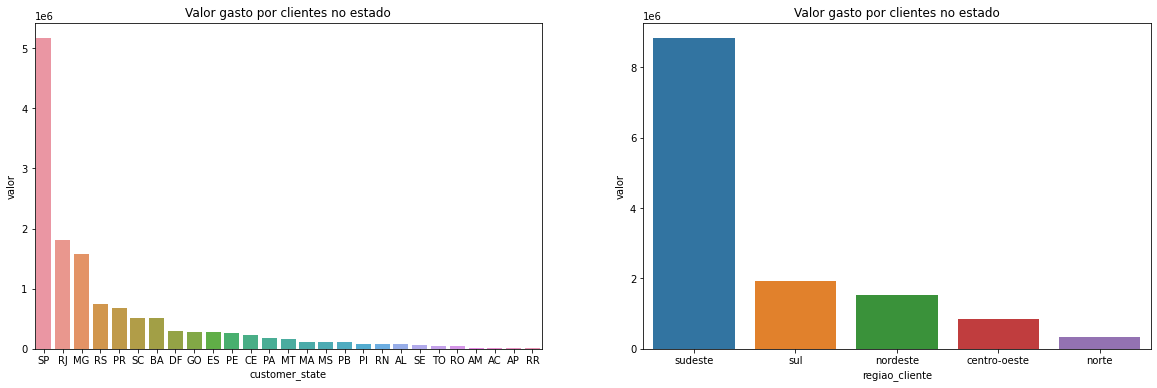

In [0]:
#soma os valores pagos por clientes em cada estado e nas regiões
df_pagmentos_state = df_basico.groupby("customer_state").agg(valor=("price", np.sum)).sort_values(by="valor", ascending=False)
df_pagmentos_regiao = df_basico.groupby("regiao_cliente").agg(valor=("price", np.sum)).sort_values(by="valor", ascending=False)

#imprime um gráfico de colunas com a quantidade de clientes por estado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x=df_pagmentos_state.index, y=df_pagmentos_state["valor"], ax=axes[0]).set_title("Valor gasto por clientes no estado")
sns.barplot(x=df_pagmentos_regiao.index, y=df_pagmentos_regiao["valor"], ax=axes[1]).set_title("Valor gasto por clientes no estado")


Como apresentado a quantidade de clientes está relacionada com valor total gasto em compras, contudo se olharmos o valor médio gasto por cliente em cada estado vemos algo interessante. O estado de São Paulo é o estado com menor média de gasto é como se cada cliente tivesse gasto cerca de `R$ 150,00`, enquanto que os clientes da Paraiba tem média de gasto de `R$ 300,00`.

Ideias: Fortalecer o comércio eletronico de Paraiba.não vai funcionar, pois AC e RR tem valores altos. O que ocorre é que são compras casuais de produtos mais caros que não estão disponiveis no comercio local "tavez".


Text(0.5, 1.0, 'Valor médio de cada compra')

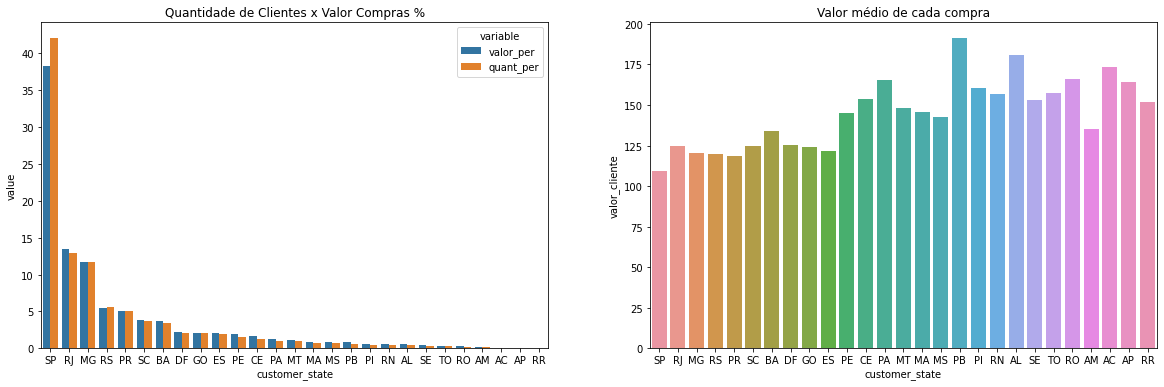

In [0]:
df_pagamentos_states = df_basico.groupby("customer_state").agg(valor=("price", np.sum), quantidade=("customer_unique_id", "count")).sort_values(by="valor", ascending=False)

#
df_cust_cp1 = df_pagamentos_states.assign(valor_per= df_pagamentos_states["valor"] / df_pagamentos_states["valor"].sum() * 100  )
df_cust_cp1 = df_cust_cp1.assign(quant_per= df_cust_cp1["quantidade"] / df_cust_cp1["quantidade"].sum() * 100  )
df_cust_cp1 = df_cust_cp1.reset_index()
df_cust_cp1 = df_cust_cp1.melt(id_vars="customer_state", value_vars=["valor_per", "quant_per"])

#
df_cust_cp2 = df_pagamentos_states.assign(valor_cliente= df_pagamentos_states["valor"] / df_pagamentos_states["quantidade"] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x="customer_state", y="value", ax=axes[0], data=df_cust_cp1, hue="variable").set_title("Quantidade de Clientes x Valor Compras %")
sns.barplot(x=df_cust_cp2.index, y=df_cust_cp2["valor_cliente"], ax=axes[1]).set_title("Valor médio de cada compra")


In [0]:
x = ibge.sort_values(by="populacao_estimada_2019", ascending=False)
x.head(3)

Estado  UF  ...  per_capita_domiciliar_2019  total_veiculos_2018
24       São Paulo  SP  ...                        1946             29057749
12    Minas Gerais  MG  ...                        1358             11191341
18  Rio de Janeiro  RJ  ...                        1882              6725822

[3 rows x 11 columns]

In [0]:
x = ibge.sort_values(by="per_capita_domiciliar_2019", ascending=False)
x.head(3)

Estado  UF  ...  per_capita_domiciliar_2019  total_veiculos_2018
6   Distrito Federal  DF  ...                        2686              1812473
24         São Paulo  SP  ...                        1946             29057749
18    Rio de Janeiro  RJ  ...                        1882              6725822

[3 rows x 11 columns]

In [0]:
quant_clientes_estados = clientes['customer_state'].value_counts().to_frame()
quant_clientes_estados.rename(columns={"customer_state": "quantidade"}, inplace=True)
#quant_clientes_estados["quantidade"] = np.log10(quant_clientes_estados["quantidade"])
quant_clientes_estados["porcentagem"] = quant_clientes_estados["quantidade"] / quant_clientes_estados["quantidade"].sum() * 100


quant_clientes_estados = pd.merge(quant_clientes_estados, ibge, how="inner", left_index=True, right_on="UF")
quant_clientes_estados = pd.merge(quant_clientes_estados, df_regiao, how="inner", left_on="UF", right_on="seller_state")
quant_clientes_estados["populacao_estimada_2019l"] = np.log10(quant_clientes_estados["populacao_estimada_2019"])
quant_clientes_estados["per_capita_domiciliar_2019l"] = np.log10(quant_clientes_estados["per_capita_domiciliar_2019"])
#quant_clientes_estados

plt.figure(figsize=(14,14))
fig = px.scatter_3d(quant_clientes_estados, x='UF', y='populacao_estimada_2019', z='per_capita_domiciliar_2019',  size='quantidade', color="regiao_vendedor", size_max=100, log_y=True, log_z=True)
fig.show()

#imprime um gráfico de colunas com a quantidade de clientes por estado
#fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
#sns.sca(x="UF", y="populacao_estimada_2019", ax=axes[0], data=quant_clientes_estados).set_title("Valor gasto por clientes no estado")
#sns.barplot(x="UF", y="per_capita_domiciliar_2019", ax=axes[1], data=quant_clientes_estados).set_title("Valor gasto por clientes no estado")


<Figure size 1008x1008 with 0 Axes>

### **Dataset Vendedores:** 

A maior parte dos vendedores estão da região Sudeste, sendo São Paulo o estado que possui mais vendedores. A região norte é a região de possui menos vendedores.

Text(0.5, 1.0, 'Quantidade de Vendedores por Região')

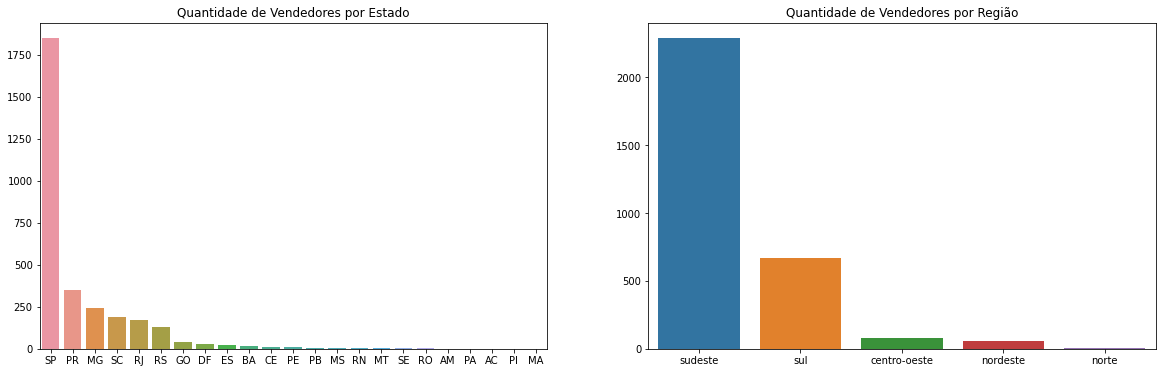

In [0]:
#conta quantos clientes existe por estado e por região
quant_vendedores_estados = sellers['seller_state'].value_counts()
quant_vendedores_regiao = sellers['regiao_vendedor'].value_counts()

#imprime um gráfico de colunas com a quantidade de clientes por estado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x=quant_vendedores_estados.index, y=quant_vendedores_estados.values, ax=axes[0]).set_title("Quantidade de Vendedores por Estado")
sns.barplot(x=quant_vendedores_regiao.index, y=quant_vendedores_regiao.values, ax=axes[1]).set_title("Quantidade de Vendedores por Região")

O Valor ganho em vendas, desconsiderando o valor do frete o em cada estado é proporcional a quantidade de vendedores de cada estado. No entanto, a região nordeste que possui menos vendedores, conseguiu obter um lucro maior do que a região centro-oeste,que possui mais vendedores.


Text(0.5, 1.0, 'Valor ganho por vendedor no estado')

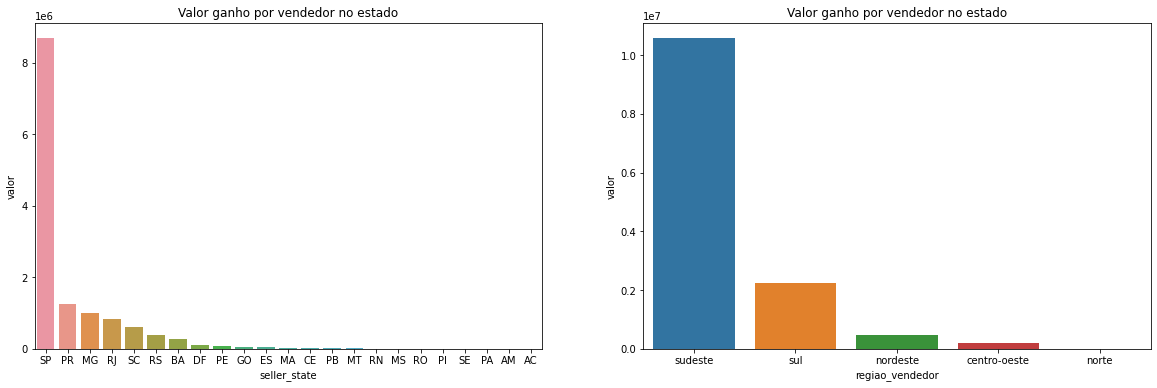

In [0]:
#soma os valores pagos por vendedores em cada estado e nas regiões
df_pagmentos_state = df_basico.groupby("seller_state").agg(valor=("price", np.sum)).sort_values(by="valor", ascending=False)
df_pagmentos_regiao = df_basico.groupby("regiao_vendedor").agg(valor=("price", np.sum)).sort_values(by="valor", ascending=False)

#imprime um gráfico de colunas com a quantidade de clientes por estado
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x=df_pagmentos_state.index, y=df_pagmentos_state["valor"], ax=axes[0]).set_title("Valor ganho por vendedor no estado")
sns.barplot(x=df_pagmentos_regiao.index, y=df_pagmentos_regiao["valor"], ax=axes[1]).set_title("Valor ganho por vendedor no estado")


Text(0.5, 1.0, 'Valor médio de cada venda')

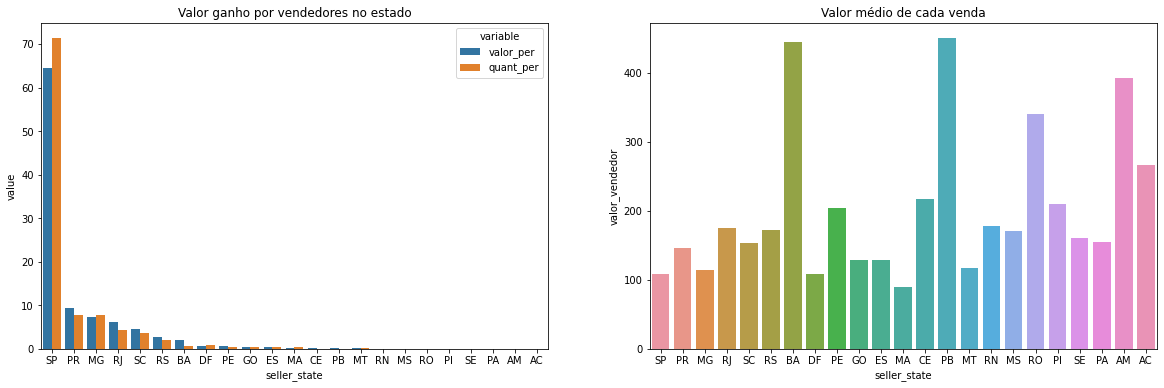

In [0]:
df_pagamentos_states = df_basico.groupby("seller_state").agg(valor=("price", np.sum), quantidade=("seller_id", "count")).sort_values(by="valor", ascending=False)

#
df_cust_cp1 = df_pagamentos_states.assign(valor_per= df_pagamentos_states["valor"] / df_pagamentos_states["valor"].sum() * 100  )
df_cust_cp1 = df_cust_cp1.assign(quant_per= df_cust_cp1["quantidade"] / df_cust_cp1["quantidade"].sum() * 100  )
df_cust_cp1 = df_cust_cp1.reset_index()
df_cust_cp1 = df_cust_cp1.melt(id_vars="seller_state", value_vars=["valor_per", "quant_per"])

#
df_cust_cp2 = df_pagamentos_states.assign(valor_vendedor= df_pagamentos_states["valor"] / df_pagamentos_states["quantidade"] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
sns.barplot(x="seller_state", y="value", ax=axes[0], data=df_cust_cp1, hue="variable").set_title("Valor ganho por vendedores no estado")
sns.barplot(x=df_cust_cp2.index, y=df_cust_cp2["valor_vendedor"], ax=axes[1]).set_title("Valor médio de cada venda")

### **Dataset Pedidos:** 

Observando o status dos pedidos verificamos que a grande maioria, cerca de 97% dos pedidos foram entregues. 

Text(0.5, 1.0, 'Status dos pedidos')

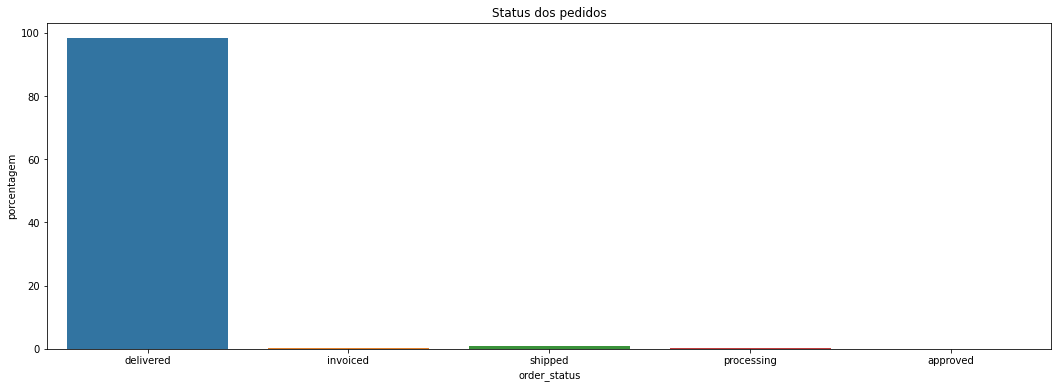

In [0]:
df_status_orders = df_basico.groupby("order_status").agg(quantidade=("order_status", "count")).sort_values(by="quantidade", ascending=False)
df_status_orders["porcentagem"] = df_status_orders["quantidade"] / df_status_orders["quantidade"].sum() * 100
df_status_orders
plt.figure(figsize=(18, 6))
sns.barplot(x=df_status_orders.index, y=df_status_orders["porcentagem"]).set_title("Status dos pedidos")

O maior número de pedidos ocorre no mês no final do mês de novembro,próximo a blackfriday.

Text(0.5, 1.0, 'Vendas por período')

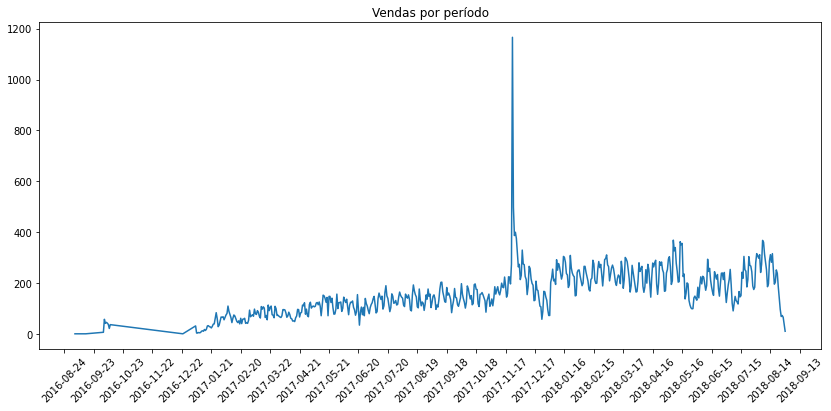

In [0]:
#df_mes_quant = df_basico.set_index("order_purchase_timestamp")
#df_mes_quant = df_mes_quant.groupby(pd.Grouper(freq="M")).agg(quantidade=("order_id", "count"))                                         
#pega apenas a coluna data da compra
df_mes_quant = orders.loc[: , ["order_purchase_timestamp"]]
#transforma a coluna data da compra (datetime) em date
df_mes_quant["date"] = df_mes_quant["order_purchase_timestamp"]
#conta a quantidade de datas iguais (pedidos por daa)
df_mes_quant = df_mes_quant["date"].value_counts()
#imprime o gráfico de pedidos por data
plt.figure(figsize=(14,6))
g = sns.lineplot(x=df_mes_quant.index, y=df_mes_quant.values)
plt.xticks(rotation=45)
#imprime de 30 em 30 dias
g.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.set_title("Vendas por período")

Os dados referentes a prazo de entrega e dias necessarios para entrega no inicio de agosto e Outubro de 2016 parecem estar com problemas, ou estão relacionados podem estar relacionados a eventos policicos como o impecheman da presidente Dilma e as Eleições Municipais.

Em geral as entregas são realizadas antes do prazo previsto.

Entre os dias 21 a 27 de maio de ocorreu a greve dos caminhoneiros aumento da pespectiva do prazo de entrega, mas na pratica houve um aumento real do prazo.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'tempo entrega por período')

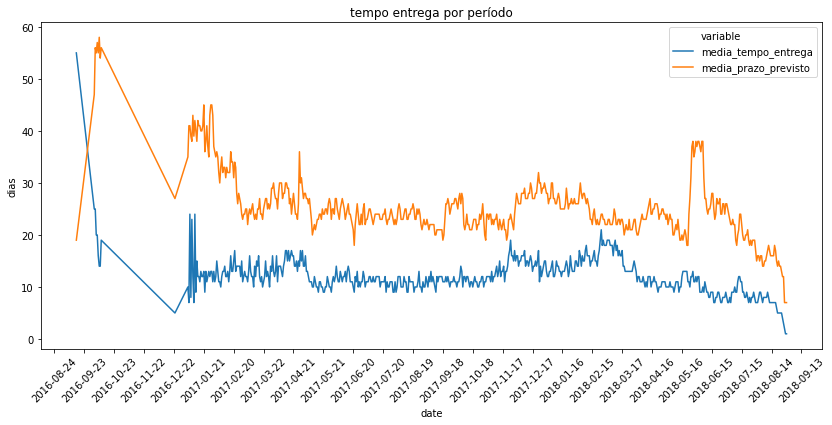

In [0]:
#seleciona a coluna data da compra e diferenca entre a estimativa a entrega do pedido
df_basico_entregue = orders.loc[(orders["order_status"].eq("delivered")) ]
#transforma a coluna data da compra (datetime) em date
df_basico_entregue["date"] = df_basico_entregue["order_purchase_timestamp"]
#conta a quantidade de datas iguais (pedidos por daa)
df_basico_entregue = df_basico_entregue.groupby("date").agg(tempo_entrega=("tempo_de_entrega", np.sum), prazo_previsto=("prazo_de_entrega", np.sum), quantidade=("date", "count"))
df_basico_entregue = df_basico_entregue.assign(media_tempo_entrega = df_basico_entregue["tempo_entrega"] / df_basico_entregue["quantidade"] )
df_basico_entregue = df_basico_entregue.assign(media_prazo_previsto = df_basico_entregue["prazo_previsto"] / df_basico_entregue["quantidade"] )
df_basico_entregue = df_basico_entregue.reset_index()
df_basico_entregue = df_basico_entregue.melt(id_vars="date", value_vars=["media_tempo_entrega", "media_prazo_previsto"], value_name="dias")
df_basico_entregue["dias"] = df_basico_entregue["dias"].dt.days
#imprime o gráfico de pedidos por data
plt.figure(figsize=(14,6))
g = sns.lineplot(x="date", y="dias", hue="variable", data=df_basico_entregue)
plt.xticks(rotation=45)
#imprime de 30 em 30 dias
g.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.set_title("tempo entrega por período")


O Mapa de calor reforça o que foi apresentado anteriormente, a região Sudeste possui os vendedores que realizam a maior quantidade de vendas e atendem as demais regiões. A maior parte do comércio está localizado na região sudeste,tanto em termos de compra quanto de venda.

De todas as regiões que adquirem produtos da região Sudeste, a região Norte é a que menos adqurire produtos, no entanto, se comparado com as compras realziadas nas outras regiões o total comprado da região Sudeste ainda ainda é muito superior.

A região Sudeste além de realizar diversas vendas, também realiza muitas compras. No entanto, apenas a reião Sul consegue realizar muitas vendas para região Sudeste.

Observa-se que os comércios dentro das próprias regiões são limitados, excetuando a Região Sudeste e a Região Sul.

A região Norderte e a região Centro-Oeste possui uma quantidade de compras consideravel da região Sudeste, mas realizam pouquissimas compras de outras regiões, bem como da sua própria região.

O ponto principal é melhorar a quantidade de vendedores nas outras regiões, buscando oferecer produtos regionais que sejam de interesse da região Sudeste, de forma a captar uma parcela dos compradores dessa regiões.

[Text(0, 0.5, 'centro-oeste'),
 Text(0, 1.5, 'nordeste'),
 Text(0, 2.5, 'norte'),
 Text(0, 3.5, 'sudeste'),
 Text(0, 4.5, 'sul')]

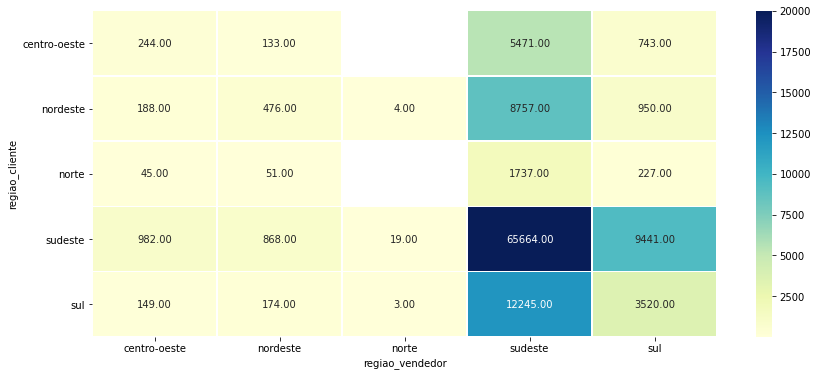

In [0]:
agrupado = df_basico.groupby(["regiao_cliente", "regiao_vendedor"]).agg(quantidade=('product_id', 'count'))
agrupado = agrupado.reset_index()
agrupado_pivot = agrupado.pivot(index="regiao_cliente", columns="regiao_vendedor", values="quantidade")
fig, axes = plt.subplots(ncols=1, figsize=(14, 6))
sns.heatmap(agrupado_pivot,  annot=True,  fmt='.2f', vmax=20000, linewidths=0.5, cmap="YlGnBu", ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0)

Mostra o valor médio do frete entre as regiões.

[Text(0, 0.5, 'centro-oeste'),
 Text(0, 1.5, 'nordeste'),
 Text(0, 2.5, 'norte'),
 Text(0, 3.5, 'sudeste'),
 Text(0, 4.5, 'sul')]

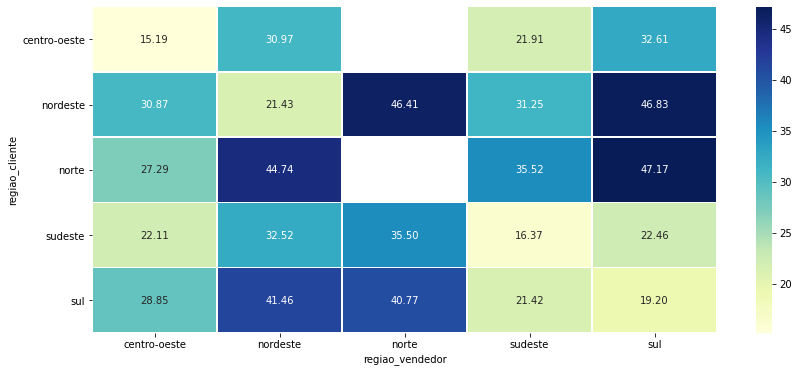

In [0]:
df_group_valores = df_basico.groupby(["order_id", "seller_id"]).agg(total_pedido=("price", np.sum), frete=("freight_value", np.sum), num_itens=("order_item_id", "count") )
df_group_valores = df_group_valores.reset_index()
df_group_valores = pd.merge(orders, df_group_valores, how="inner", on="order_id")
df_group_valores = pd.merge(customers, df_group_valores, how="inner", on="customer_id")
df_group_valores = pd.merge(sellers, df_group_valores, how="inner", on="seller_id")
df_group_valores_a = df_group_valores.groupby(["regiao_vendedor", "regiao_cliente"]).agg(frete=("frete", np.sum), quantidade=("num_itens", np.sum)).sort_values(by="frete", ascending=False)
df_group_valores_a = df_group_valores_a.assign(media_frete= df_group_valores_a["frete"] / df_group_valores_a["quantidade"] )

df_group_valores_a = df_group_valores_a.reset_index()
df_group_valores_a = df_group_valores_a.pivot(index="regiao_cliente", columns="regiao_vendedor", values="media_frete")
fig, axes = plt.subplots(ncols=1, figsize=(14, 6))
sns.heatmap(df_group_valores_a,  annot=True,  fmt='.2f', linewidths=0.5, cmap="YlGnBu", ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0)



[Text(0, 0.5, 'sudeste')]

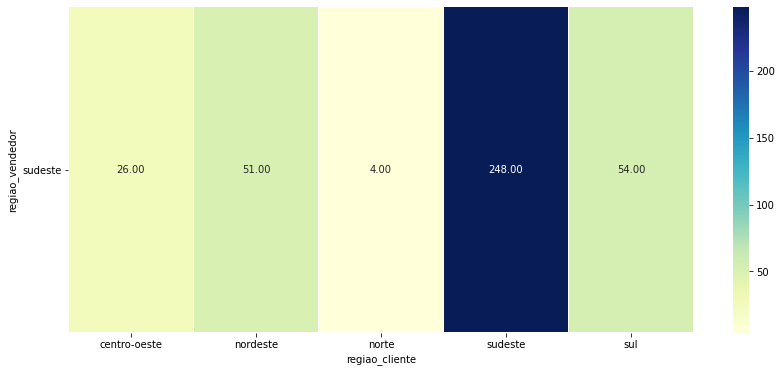

In [0]:
#quantidade de fretes gratuitos
df_group_valores = df_basico.loc[(df_basico["freight_value"] == 0)]
df_group_valores_a = df_group_valores.groupby(["regiao_vendedor", "regiao_cliente"]).agg(quantidade=("freight_value", "count"))
df_group_valores_a = df_group_valores_a.reset_index()
df_group_valores_a = df_group_valores_a.pivot(index="regiao_vendedor", columns="regiao_cliente", values="quantidade")
fig, axes = plt.subplots(ncols=1, figsize=(14, 6))
sns.heatmap(df_group_valores_a,  annot=True,  fmt='.2f', linewidths=0.5, cmap="YlGnBu", ax=axes)
axes.set_yticklabels(axes.get_yticklabels(), rotation=0)

### **Dataset Produtos:** 

Considerando os 10 produtos mais vendidos temos que a média de valor dos produtos é de `R$ 80,89`, o valor do frete é de `R$ 18,72`, o nome do produto tem em média 51 caracteres, a descrição possui em média 642 caracteres, a quantidade de fotos de 2 e o peso média de 1,8kg.

In [0]:
#agrupa os produtos produtos e conta a quantidade de vendas por produto,soma 
produtos_qdt_vendas = df_basico.groupby("product_id").agg(quantidade=('product_id', 'count'), 
                                                                        valor_acumulado=('price', np.sum), 
                                                                        frete_acumulado=('freight_value', np.sum), 
                                                                        media_valor=('price', np.average), 
                                                                        media_frete=('freight_value', np.average))

products_item_number_sellers = pd.merge(produtos_qdt_vendas,products, on="product_id",how="inner")
products_item_number_sellers = products_item_number_sellers.sort_values(by="quantidade", ascending=False)

#remove colunas para gerar gráfico de dispersão
features_products = products_item_number_sellers.drop(columns=["valor_acumulado", "frete_acumulado", "product_id", "product_category_name", "product_length_cm", "product_height_cm", "product_width_cm", "volume"])


#divide o grupo de produtos em dois, o segundo grupo tem os 10 produtos mais vendidos
bins = features_products["quantidade"].value_counts(bins=2)
for c in features_products.columns:
  b = features_products.loc[((features_products["quantidade"] >= bins.index[1].left) & (features_products["quantidade"] <= bins.index[1].right))]
  print(c, ":", "{:.2f}".format(b[c].mean()))

quantidade : 386.90
media_valor : 80.48
media_frete : 18.72
product_name_lenght : 51.60
product_description_lenght : 642.80
product_photos_qty : 2.10
product_weight_g : 1820.00


Os gráficos abaixo apresentam a concentração de produtos

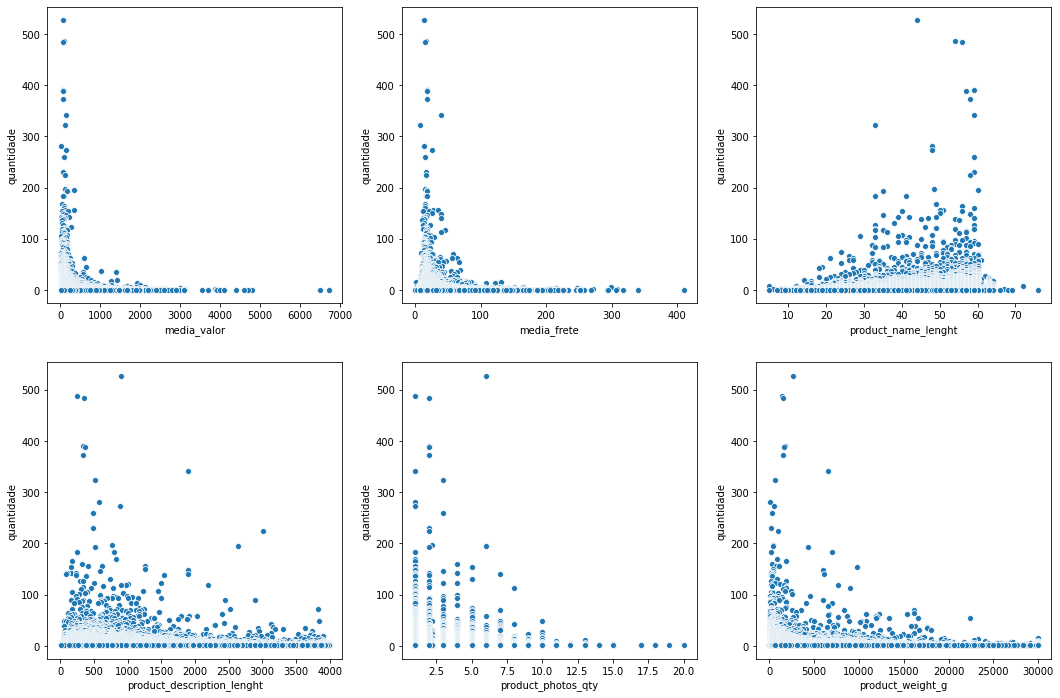

In [0]:
#gera o gráfico de boxplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
j = 0; i = 0 

for c in features_products.columns:  
  if c != "quantidade":
    sns.scatterplot(x=c, y="quantidade",  ax=axes[i][j], data=features_products)
    if (j < 2):    
      j = j + 1                
    else: 
      j = 0; 
      i = 1  
plt.show()

A categoria de produto mais vendida na Olist é cama, mesa e banho, no entanto, em termos de valor total de venda, essa categoria é a terceira. 

A categoria de produtos de beleza e saúde possui o maior valor em vendas e é a segunda em quantidade de vendas.

A quantidade de vendas parece estar relacionada com o valor total de frete, quanto mais entregas (vendas) se faz mais frete é cobrado. Existe uma pequena troca entre as posições 3 e 4 (decoração e esporte), o que indica que o frete dos produtos esportivos são mais baratos que os produtos da categoria moveis e decoração.

Text(0.5, 1.0, 'Categoria x Valor total de vendas')

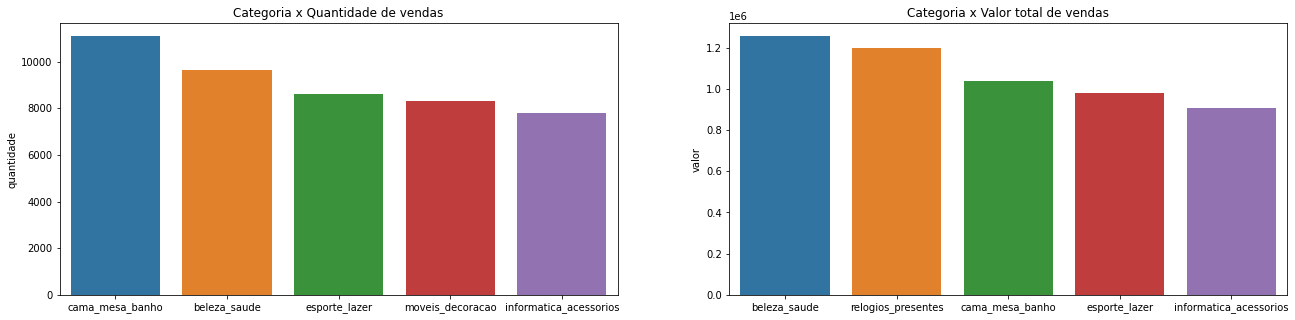

In [0]:
#vamos verificar quais categorias de produtos foram mais vendidas 
quant_produ_categ = df_basico.groupby('product_category_name').agg(quantidade=('product_id', 'count'), 
                                                                        valor=('price', np.sum), 
                                                                        frete=('freight_value', np.sum), 
                                                                        media_valor=('price', np.average), 
                                                                        media_frete=('freight_value', np.average), 
                                                                        media_char_nome=('product_name_lenght', np.average),
                                                                        media_char_descricao=('product_description_lenght', np.average),
                                                                        media_fotos=('product_photos_qty', np.average),
                                                                        media_peso=('product_weight_g', np.average))#pega os 5 maiores valores de quantidade, valor e frete

#pega os 5 maiores valores 
df5max_qty = quant_produ_categ['quantidade'].nlargest(5)
df5max_valor = quant_produ_categ['valor'].nlargest(5)
df5max_frete = quant_produ_categ['frete'].nlargest(5)

#imprime o gráfico
fig, axes = plt.subplots(ncols=2, figsize=(22, 5))
#plt.subplots_adjust(hspace=1)
chart1 = sns.barplot(x=df5max_qty.index.tolist(), y=df5max_qty, ax=axes[0]).set_title("Categoria x Quantidade de vendas")
#axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=25)

sns.barplot(x=df5max_valor.index.tolist(), y=df5max_valor, ax=axes[1], ).set_title("Categoria x Valor total de vendas")
#axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=25)

#sns.barplot(x=df5max_frete.index.tolist(), y=df5max_frete, ax=axes[2]).set_title("Categoria x Valor total do frete")
#axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=25)

Calculamos a correção das variáveis e não observamos correção entre a quantidade de vendas e as demais caracteristicas dos produtos. As correlações observadas estão relacionadas as dimensões (volume), peso e frete do produto.

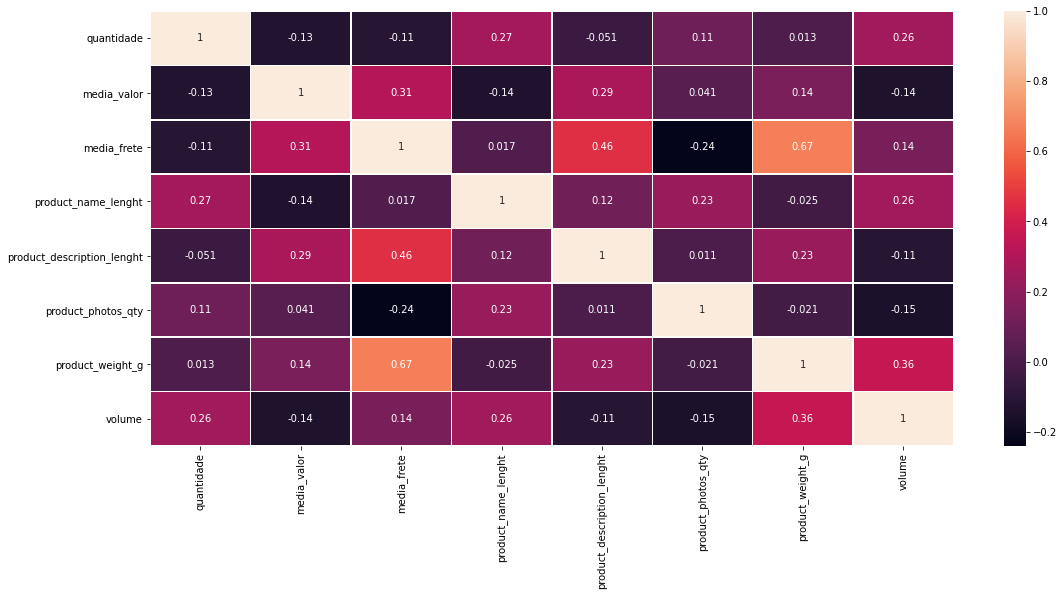

In [0]:
features_products = products_item_number_sellers.drop(columns=["valor_acumulado", "frete_acumulado", "product_id", "product_category_name", "product_length_cm", "product_height_cm", "product_width_cm"])
features_products = features_products.loc[(features_products["quantidade"] > 100)]
#faz a correlação das colunas
correlation = features_products.corr()
plt.figure(figsize=(18,8))
sns.heatmap(correlation, annot=True, fmt=".2g", linewidths=0.5)
#0.9 a 1 positivo ou negativo indica uma correlação muito forte.
#0.7 a 0.9 positivo ou negativo indica uma correlação forte.
#0.5 a 0.7 positivo ou negativo indica uma correlação moderada.
#0.3 a 0.5 positivo ou negativo indica uma correlação fraca.
#0 a 0.3 positivo ou negativo indica uma correlação desprezível.
#features_products

### **Dataset Pagamento:** 

Método preferido de pagamento é o cartão de credito.

Text(0, 0.5, 'Valor acumulado')

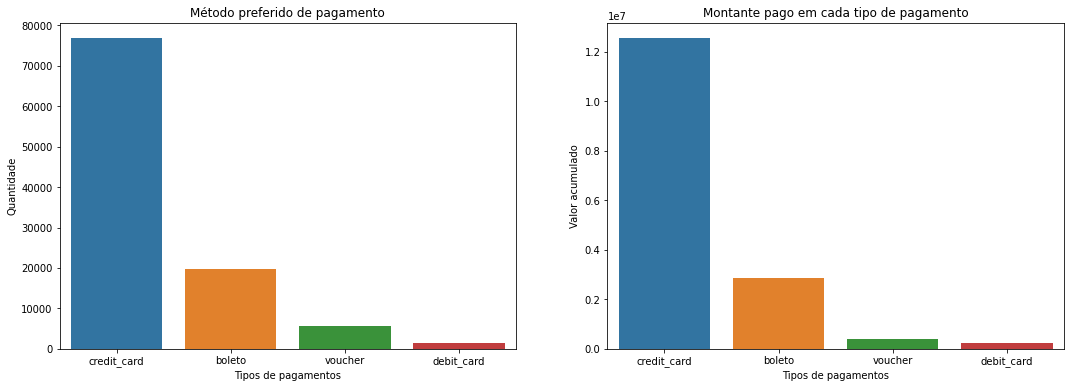

In [0]:
total_type = payments.groupby("payment_type").agg(total=("payment_value", np.sum)).sort_values(by="total", ascending=False)
quantidade_type = payments["payment_type"].value_counts(ascending=False)
fig, axes = plt.subplots(ncols=2, figsize=(18,6))
sns.barplot(x=quantidade_type.index, y=quantidade_type.values, ax=axes[0]).set_title("Método preferido de pagamento")
axes[0].set_xlabel("Tipos de pagamentos")
axes[0].set_ylabel("Quantidade")
g1 = sns.barplot(x=total_type.index, y="total", data=total_type, ax=axes[1])
g1.set_title("Montante pago em cada tipo de pagamento")
g1.set_xlabel("Tipos de pagamentos")
g1.set_ylabel("Valor acumulado")

Os pagamentos preferencialmente são realizados em 1 parcela, no entanto, as compras paga em 1 parcela possuem valores baixo, em torno de 100 reais. Compras de valores mais altos, em torno de 600 reais são pagas em 20 e 24 parcelas.

Text(0, 0.5, 'Valor médio dos pedidos')

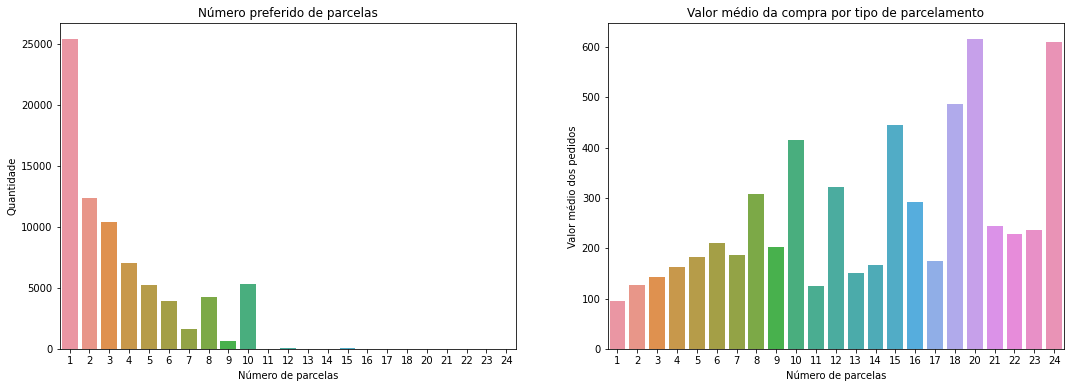

In [0]:
total_type2 = payments.loc[(payments["payment_type"].eq("credit_card"))].groupby(["payment_installments"]).agg(total=("payment_value", np.sum), quantidade=("payment_value", "count")).sort_values(by=["payment_installments"], ascending=(True))
total_type2 = total_type2.assign(media_total=total_type2["total"]/total_type2["quantidade"])
fig, axes = plt.subplots(ncols=2, figsize=(18,6))
sns.barplot(x=total_type2.index, y="quantidade", data=total_type2, ax=axes[0]).set_title("Número preferido de parcelas")
sns.barplot(x=total_type2.index, y="media_total", data=total_type2, ax=axes[1]).set_title("Valor médio da compra por tipo de parcelamento")
axes[0].set_xlabel("Número de parcelas")
axes[0].set_ylabel("Quantidade")
axes[1].set_xlabel("Número de parcelas")
axes[1].set_ylabel("Valor médio dos pedidos")

### **Dataset Avaliação:** 

Cria funções para geração de nuvens de palavras.

In [0]:
def get_nuvem(message):
    palavras = ''
    for msg in message:
        msg = msg.lower()
        palavras += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color='black').generate(palavras)
    return wordcloud

def get_nuvem_by_score(score):
  avaliacoes = reviews.loc[~(reviews['review_comment_message']).isna()]
  message = avaliacoes[avaliacoes['review_score'] == score]['review_comment_message']    
  return get_nuvem(message)

def get_nuvem_title_by_score(score):
  avaliacoes = reviews.loc[~(reviews['review_comment_title']).isna()]
  message = avaliacoes[avaliacoes['review_score'] == score]['review_comment_title']    
  return get_nuvem(message)

def get_nuvem_msg_by_score(score):
  avaliacoes = reviews.loc[~(reviews['review_comment_message']).isna()]
  message = avaliacoes[avaliacoes['review_score'] == score]['review_comment_message']    
  return get_nuvem(message)


Em geral as compras são bem avaliadas.

Text(0.5, 0, 'Score')

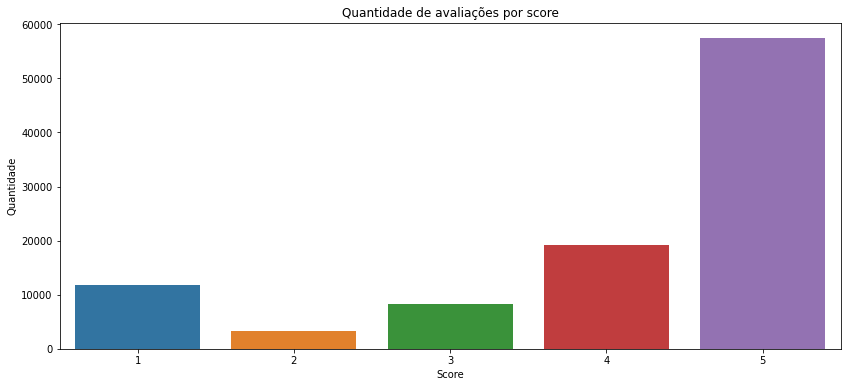

In [0]:
count_avaliacoes = reviews["review_score"].value_counts()
plt.figure(figsize=(14,6))
g = sns.barplot(x=count_avaliacoes.index, y=count_avaliacoes.values)
g.set_title("Quantidade de avaliações por score")
g.set_ylabel("Quantidade")
g.set_xlabel("Score")

Text(0.5, 0, 'Data de realização do pedido')

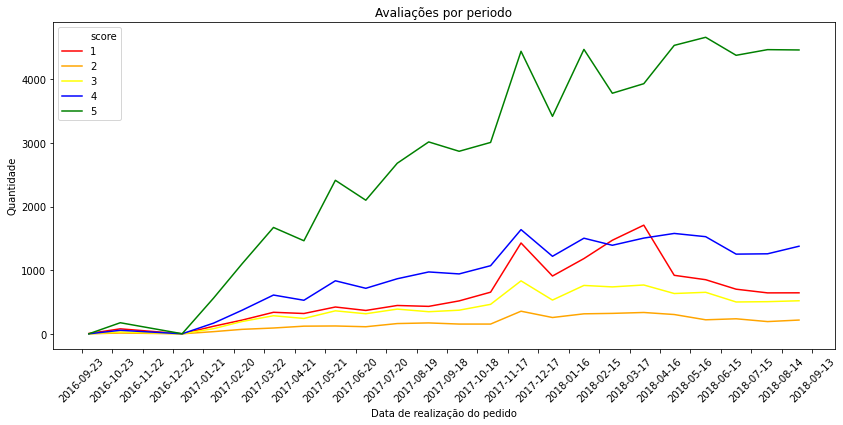

In [0]:
df_avaliacao_quant = dfb_reviews.copy()
df_avaliacao_quant["order_purchase_timestamp"] = pd.to_datetime(df_avaliacao_quant["order_purchase_timestamp"])
df_avaliacao_quant = df_avaliacao_quant.set_index("order_purchase_timestamp")
df_avaliacao_quant = df_avaliacao_quant.groupby([pd.Grouper(freq="M"), "review_score"]).agg(quantidade=("review_score", "count"))  
df_avaliacao_quant = df_avaliacao_quant.reset_index()
#transforma linhas em colunas, para preencher as colunas sem valor com 0 #corrige erro da imagem no gráfico
df_avaliacao_quant = df_avaliacao_quant.pivot(index="order_purchase_timestamp",columns="review_score", values="quantidade")
#preenche datas sem avaliação com 0
df_avaliacao_quant = df_avaliacao_quant.fillna(0)
#volta a fundir as colunas de score em uma unica tabela
df_avaliacao_quant = df_avaliacao_quant.reset_index()
df_avaliacao_quant = df_avaliacao_quant.melt(id_vars="order_purchase_timestamp", value_vars=[1, 2, 3, 4, 5], var_name="score")

#imprime o gráfico de pedidos por data
plt.figure(figsize=(14,6))
g = sns.lineplot(x="order_purchase_timestamp", y="value", hue="score", data=df_avaliacao_quant, palette=["red", "orange", "yellow", "blue", "green"])
plt.xticks(rotation=45)
#imprime de 30 em 30 dias
g.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.set_title("Avaliações por periodo")
g.set_ylabel("Quantidade")
g.set_xlabel("Data de realização do pedido")

Em fevereiro e março de 2017 houve um aumento no número de avaliações negativas. Qual o motivo?

Text(0.5, 0, 'Data de realização do pedido')

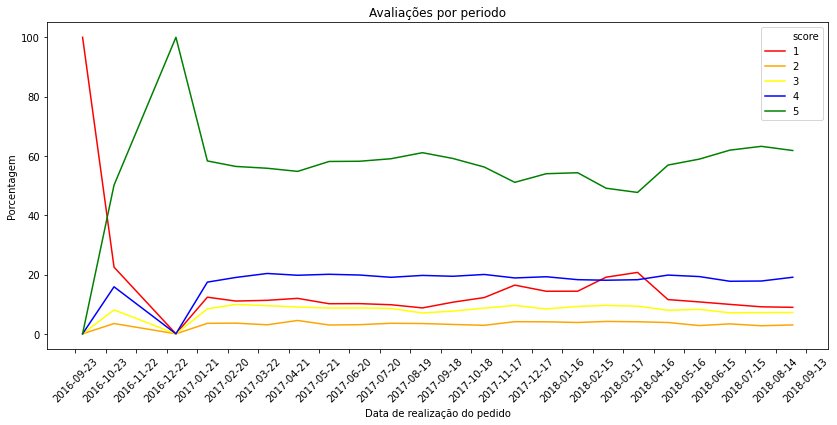

In [0]:
df_avaliacao_quant = dfb_reviews.copy()
df_avaliacao_quant["order_purchase_timestamp"] = pd.to_datetime(df_avaliacao_quant["order_purchase_timestamp"])
df_avaliacao_quant = df_avaliacao_quant.set_index("order_purchase_timestamp")
df_avaliacao_quant = df_avaliacao_quant.groupby([pd.Grouper(freq="M"), "review_score"]).agg(quantidade=("review_score", "count"))  
df_avaliacao_quant = df_avaliacao_quant.reset_index()
#transforma linhas em colunas, para preencher as colunas sem valor com 0 #corrige erro da imagem no gráfico
df_avaliacao_quant = df_avaliacao_quant.pivot(index="order_purchase_timestamp",columns="review_score", values="quantidade")
#preenche datas sem avaliação com 0
df_avaliacao_quant = df_avaliacao_quant.fillna(0)
df_avaliacao_quant = df_avaliacao_quant.assign(total=df_avaliacao_quant[1]+df_avaliacao_quant[2]+df_avaliacao_quant[3]+df_avaliacao_quant[4]+df_avaliacao_quant[5])
df_avaliacao_quant["s1"] = df_avaliacao_quant[1] / df_avaliacao_quant["total"] * 100
df_avaliacao_quant["s2"] = df_avaliacao_quant[2] / df_avaliacao_quant["total"] * 100
df_avaliacao_quant["s3"] = df_avaliacao_quant[3] / df_avaliacao_quant["total"] * 100
df_avaliacao_quant["s4"] = df_avaliacao_quant[4] / df_avaliacao_quant["total"] * 100
df_avaliacao_quant["s5"] = df_avaliacao_quant[5] / df_avaliacao_quant["total"] * 100
df_avaliacao_quant = df_avaliacao_quant.drop(columns=[1,2,3,4,5,"total"])
df_avaliacao_quant = df_avaliacao_quant.rename(columns={"s1":"1", "s2":"2", "s3":"3", "s4":"4", "s5":"5"})
#volta a fundir as colunas de score em uma unica tabela
df_avaliacao_quant = df_avaliacao_quant.reset_index()
df_avaliacao_quant = df_avaliacao_quant.melt(id_vars="order_purchase_timestamp", value_vars=['1', '2', '3', '4', '5'], var_name="score")

#imprime o gráfico de pedidos por data
plt.figure(figsize=(14,6))
g = sns.lineplot(x="order_purchase_timestamp", y="value", hue="score", data=df_avaliacao_quant, palette=["red", "orange", "yellow", "blue", "green"])
plt.xticks(rotation=45)
#imprime de 30 em 30 dias
g.xaxis.set_major_locator(ticker.MultipleLocator(30))
g.set_title("Avaliações por periodo")
g.set_ylabel("Porcentagem")
g.set_xlabel("Data de realização do pedido")


Vamos verificar os as avaliações negativas referente aos meses de compras 15/02/2018 a 31/03/2018,quando as avaliações de score 1 superaram as avaliações de score 4. No geral as reclamações estão relacionados a não entrega dos produtos.

In [0]:
df_avaliacao_quant = dfb_reviews.copy()
df_avaliacao_quant["order_purchase_timestamp"] = pd.to_datetime(df_avaliacao_quant["order_purchase_timestamp"])
df_avaliacao_quant = df_avaliacao_quant.set_index("order_purchase_timestamp")
df_avaliacao_quant = df_avaliacao_quant.groupby([pd.Grouper(freq="M"), "review_score"]).agg(quantidade=("review_score", "count"))  
df_avaliacao_quant = df_avaliacao_quant.reset_index()
#transforma linhas em colunas, para preencher as colunas sem valor com 0 #corrige erro da imagem no gráfico
df_avaliacao_quant = df_avaliacao_quant.pivot(index="order_purchase_timestamp",columns="review_score", values="quantidade")
df_avaliacao_quant.head(3)

review_score                 1     2     3     4      5
order_purchase_timestamp                               
2016-09-30                 5.0   NaN   NaN   NaN    NaN
2016-10-31                78.0  12.0  28.0  55.0  174.0
2016-12-31                 NaN   NaN   NaN   NaN    1.0

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 1')

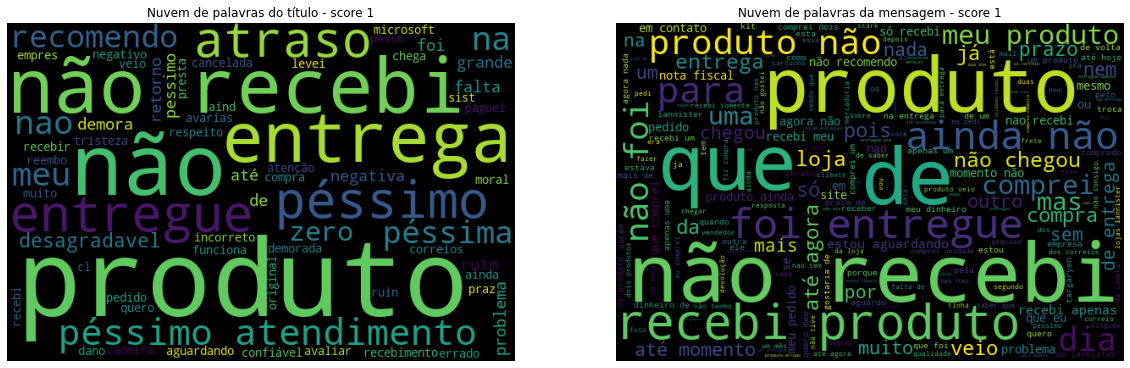

In [0]:
df_avaliacoes_ruins = dfb_reviews.loc[((dfb_reviews["review_score"] == 1) & (dfb_reviews["order_purchase_timestamp"] >= pd.Timestamp(2018,2,1)) & (dfb_reviews["order_purchase_timestamp"] <= pd.Timestamp(2018,4,1)))]
df_avaliacoes_ruins_title = df_avaliacoes_ruins.loc[(df_avaliacoes_ruins['review_comment_title'].notna())]
df_avaliacoes_ruins_msg = df_avaliacoes_ruins.loc[(df_avaliacoes_ruins['review_comment_message'].notna())]

nuvem_title = get_nuvem(df_avaliacoes_ruins_title['review_comment_title'])
nuvem_msg = get_nuvem(df_avaliacoes_ruins_msg['review_comment_message'])

#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 1")
axes[1].imshow(nuvem_msg)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 1")

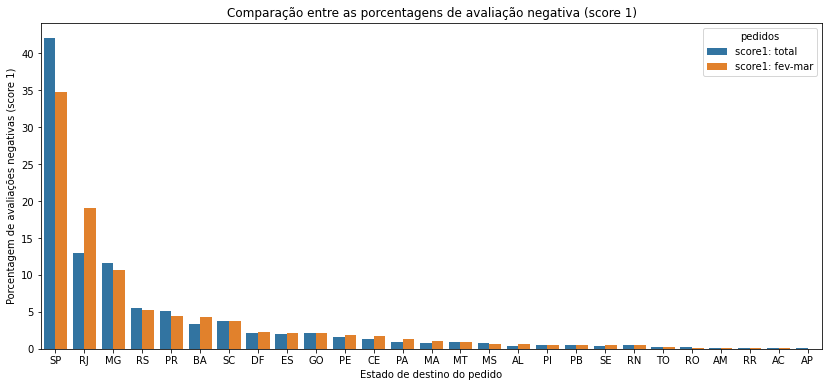

In [0]:
#df_avaliacoes_ruins2  = df_avaliacoes_ruins["customer_state"].value_counts(sort=True).to_frame()
df_avaliacoes_ruins2  = dfb_reviews.loc[(dfb_reviews["review_score"] == 1)]["customer_state"].value_counts(sort=True).to_frame()
df_compras = dfb_reviews["customer_state"].value_counts(sort=True).to_frame()

df_avaliacoes_ruins2["score1: fev-mar"] = df_avaliacoes_ruins2["customer_state"] / df_avaliacoes_ruins2["customer_state"].sum() * 100
df_compras["score1: total"] = df_compras["customer_state"] / df_compras["customer_state"].sum() * 100
df_compras.drop(columns="customer_state", inplace=True)
df_avaliacoes_ruins2.drop(columns="customer_state", inplace=True)
df = df_avaliacoes_ruins2.join(df_compras)
df = df.reset_index()
df =df.melt(id_vars="index", value_vars=["score1: fev-mar", "score1: total"], var_name="pedidos")
plt.figure(figsize=(14,6))
g = sns.barplot(x="index", y="value", hue="pedidos", data=df, hue_order=["score1: total","score1: fev-mar"])
g.set_title("Comparação entre as porcentagens de avaliação negativa (score 1)")
g.set_xlabel("Estado de destino do pedido")
g.set_ylabel("Porcentagem de avaliações negativas (score 1)")
plt.show()



As categorias melhores avaliadas em relação a quantidade de avaliações foram roupas infanto juvenil, livros importados, livros de interesse geral, cds e dvds musicais e livros técnicos. Observa-se que a categoria de livros está muito presente entre as melhores avaliadas. 

Em termos de absoluto de avaliações estão as categorias beleza e saude, cama mesa e banho, esporte e lazer,moveis e decoracao e informática e acessorios. Essas essas categorias por terem sido mais vendidas tende a receber mais avaliações, por isso em modo absoluto ocupam as primeiras posições.

Nas categorias piores avaliadas em relação ao número de vendas estão: seguros e serviços, pc_gamer, casa_conforto, la_cusine e roupa masculina. Em termos absolutos de avaliações negativas estão: cama mesa e banho, moveis e decoração, informática e acessorios, beleza e saude, esporte e lazer. Basicamente as mesmas categorias que foram melhores avaliadas em modo absoluto. Relembrando que isso ocorres, pois foram categorias que tiveram grande número de venda e portanto receberam muitas avaliações positivas e negativas.

[Text(0, 0, 'cama_mesa_banho'),
 Text(0, 0, 'moveis_decoracao'),
 Text(0, 0, 'informatica_acessorios'),
 Text(0, 0, 'beleza_saude'),
 Text(0, 0, 'esporte_lazer')]

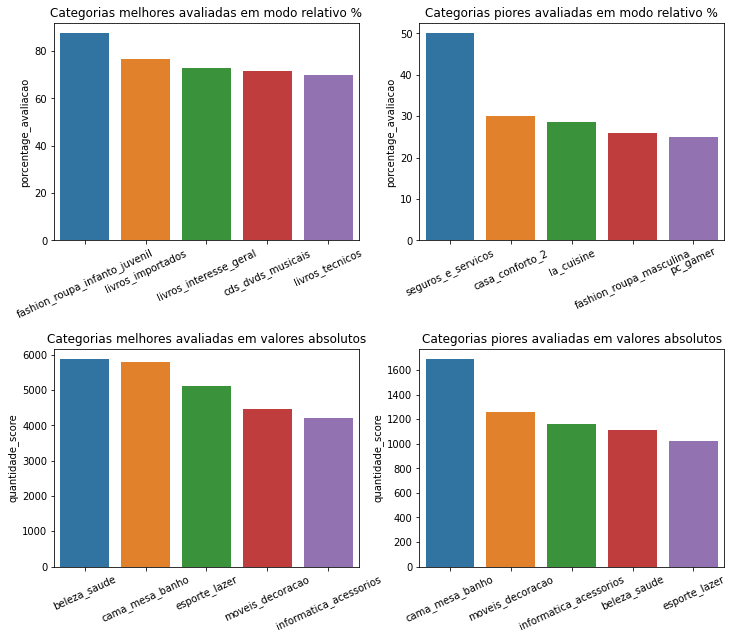

In [0]:
#faz o agrupamento e conta a quantidade de scores por tipo de score
df_avaliacao_categoria = dfb_reviews.groupby(['product_category_name', 'review_score']).agg(quantidade_score=('order_id', 'count'))
#soma quantas avaliacoes cada categoria de produtos teve
df_avaliacao_categoria2 = df_avaliacao_categoria.groupby("product_category_name").agg(quantidade_avaliacao=("quantidade_score", np.sum) )  
#reseta o indice para realizar a juncao
df_avaliacao_categoria = df_avaliacao_categoria.reset_index()
df_avaliacao_categoria2 = df_avaliacao_categoria2.reset_index()
#junta a quantidade de scores por tipo de score com a quantidade de avaliacoes por categoria
df_avaliacao = pd.merge(df_avaliacao_categoria, df_avaliacao_categoria2, on="product_category_name",how="inner")
#calcula a porcentagem dos scores avaliado em relacao ao numero de avaliacoes
df_avaliacao = df_avaliacao.assign(porcentage_avaliacao=df_avaliacao["quantidade_score"]/df_avaliacao["quantidade_avaliacao"]*100)

#filtra os melhores e piores scores e seleciona os 5 mais de cada um (relativo %)
df_categoria_best_avaliacao = df_avaliacao.loc[(df_avaliacao["review_score"] == 5)]["porcentage_avaliacao"].nlargest(5).to_frame()
df_categoria_worse_avaliacao = df_avaliacao.loc[(df_avaliacao["review_score"] == 1)]['porcentage_avaliacao'].nlargest(5).to_frame()

#filtra os melhores e piores scores e seleciona os 5 mais de cada um (absoluto)
df_categoria_best_avaliacao_abs = df_avaliacao.loc[(df_avaliacao["review_score"] == 5)]["quantidade_score"].nlargest(5).to_frame()
df_categoria_worse_avaliacao_abs = df_avaliacao.loc[(df_avaliacao["review_score"] == 1)]["quantidade_score"].nlargest(5).to_frame()

#junta os dados da categoria com as porcentagens sobre os scores de avalicao %
df_categoria_best_avaliacao = df_categoria_best_avaliacao.join(df_avaliacao_categoria)
df_categoria_best_avaliacao = df_categoria_best_avaliacao.set_index("product_category_name")
df_categoria_worse_avaliacao = df_categoria_worse_avaliacao.join(df_avaliacao_categoria)
df_categoria_worse_avaliacao = df_categoria_worse_avaliacao.set_index("product_category_name")

#junta os dados da categoria com as porcentagens sobre os scores de avalicao - absoluto
df_avaliacao_categoria = df_avaliacao_categoria.drop(columns="quantidade_score")
df_categoria_best_avaliacao_abs = df_categoria_best_avaliacao_abs.join(df_avaliacao_categoria)
df_categoria_best_avaliacao_abs = df_categoria_best_avaliacao_abs.set_index("product_category_name")
df_categoria_worse_avaliacao_abs = df_categoria_worse_avaliacao_abs.join(df_avaliacao_categoria)
df_categoria_worse_avaliacao_abs = df_categoria_worse_avaliacao_abs.set_index("product_category_name")


#imprime o gráfico
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.5)
#relativo
chart1 = sns.barplot(x=df_categoria_best_avaliacao.index.tolist(), y="porcentage_avaliacao", ax=axes[0][0], data=df_categoria_best_avaliacao).set_title("Categorias melhores avaliadas em modo relativo %")
chart2 = sns.barplot(x=df_categoria_worse_avaliacao.index.tolist(), y="porcentage_avaliacao", ax=axes[0][1], data=df_categoria_worse_avaliacao).set_title("Categorias piores avaliadas em modo relativo %")
axes[0][0].set_xticklabels(axes[0][0].get_xticklabels(), rotation=25)
axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(), rotation=25)
#valores absolutos
chart3 = sns.barplot(x=df_categoria_best_avaliacao_abs.index.tolist(), y="quantidade_score", ax=axes[1][0], data=df_categoria_best_avaliacao_abs).set_title("Categorias melhores avaliadas em valores absolutos")
chart4 = sns.barplot(x=df_categoria_worse_avaliacao_abs.index.tolist(), y="quantidade_score", ax=axes[1][1], data=df_categoria_worse_avaliacao_abs).set_title("Categorias piores avaliadas em valores absolutos")
axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(), rotation=25)
axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(), rotation=25)



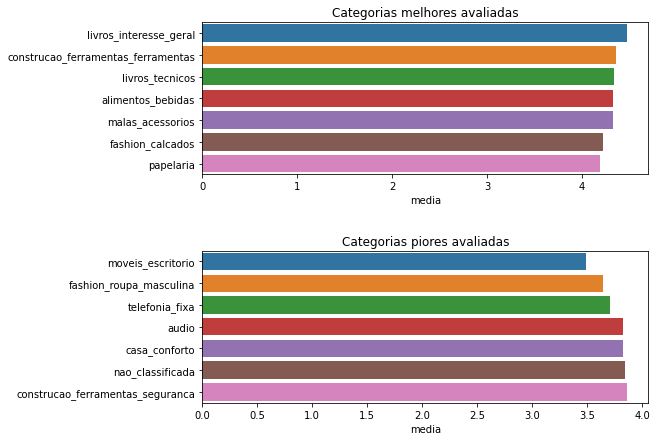

In [0]:
#cria o grafico das melhores e piores categorias avaliadas, apenas para as que tiveram mais de 50 avaliacoes
#faz o agrupamento e conta a quantidade de scores por tipo de score
df_avaliacao_categoria = dfb_reviews.groupby(['product_category_name']).agg(num_avaliacoes=('order_id', 'count'), media=("review_score", np.mean))
#77 é o primeiro quartil do numero de avaliacoes
df_avaliacao_categoria = df_avaliacao_categoria.loc[(df_avaliacao_categoria["num_avaliacoes"] > 77)].sort_values(by="media", ascending=False)
#filtra os melhores e piores scores e seleciona os 5 mais de cada um (relativo %)
df_categoria_best_avaliacao = df_avaliacao_categoria["media"].nlargest(7).to_frame()
df_categoria_worse_avaliacao = df_avaliacao_categoria['media'].nsmallest(7).to_frame()

#imprime o gráfico
fig, axes = plt.subplots(nrows=2, figsize=(8, 7))
plt.subplots_adjust(hspace=0.5)
chart1 = sns.barplot(y=df_categoria_best_avaliacao.index.tolist(), x="media",  ax=axes[0], data=df_categoria_best_avaliacao).set_title("Categorias melhores avaliadas")
chart2 = sns.barplot(y=df_categoria_worse_avaliacao.index.tolist(), x="media", ax=axes[1], data=df_categoria_worse_avaliacao).set_title("Categorias piores avaliadas")


Vamos analisar as nuvens de palavras de cada scores.

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 5')

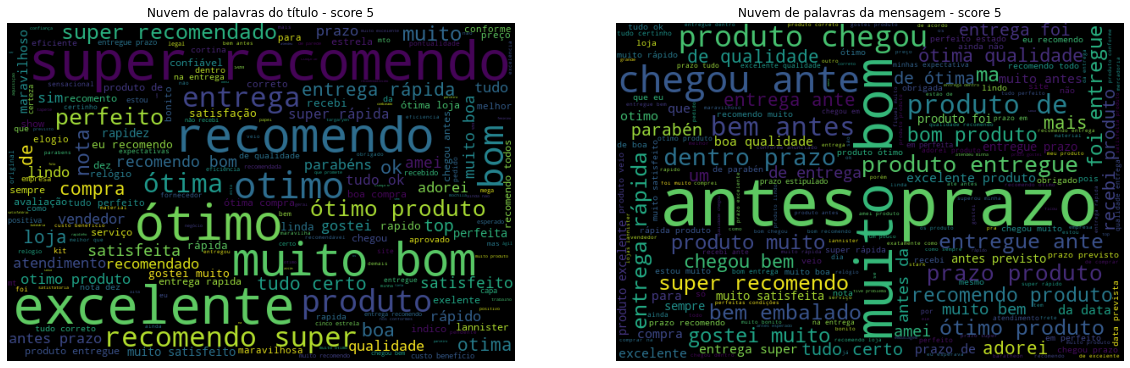

In [0]:
#obtém as nuvens de palavras do score 5
nuvem_title_5 = get_nuvem_title_by_score(5)
nuvem_msg_5 = get_nuvem_msg_by_score(5)
#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title_5)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 5")
axes[1].imshow(nuvem_msg_5)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 5")

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 4')

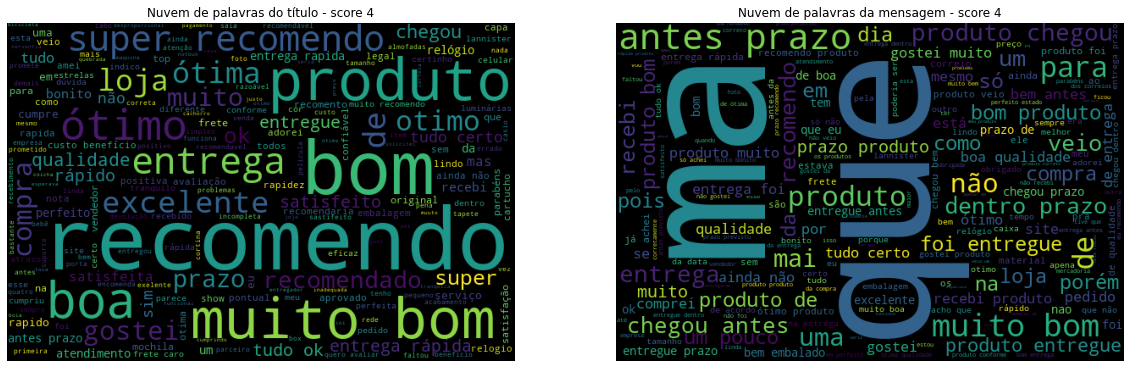

In [0]:
#obtém as nuvens de palavras do score 5
nuvem_title_5 = get_nuvem_title_by_score(4)
nuvem_msg_5 = get_nuvem_msg_by_score(4)
#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title_5)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 4")
axes[1].imshow(nuvem_msg_5)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 4")

No score 3 é possível observar no texto que as pessoas recomendam a loja/produto, que gostaram, no entanto,quando olhamos para para as mensagens verificamos que ficou algo a desejar, existe muitas palavras "mas", "porem", "não". Ou seja, faltou algo para satisfazer o cliente.

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 3')

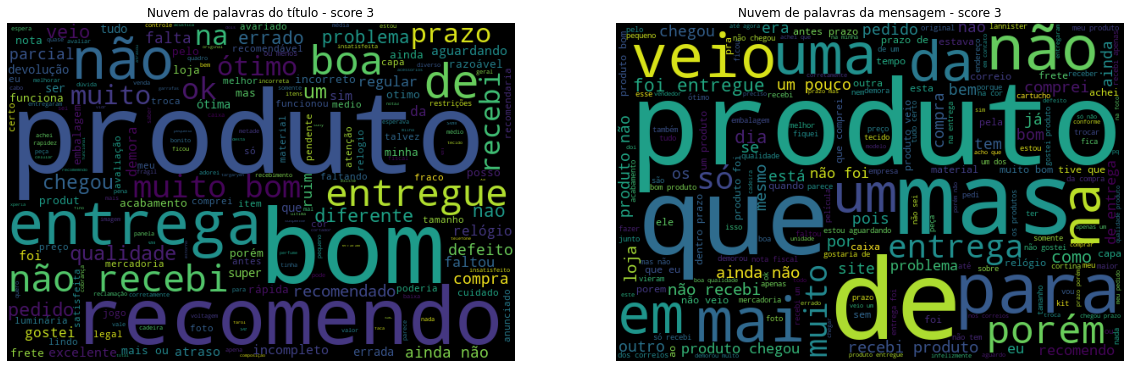

In [0]:
#obtém as nuvens de palavras do score 3
nuvem_title_5 = get_nuvem_title_by_score(3)
nuvem_msg_5 = get_nuvem_msg_by_score(3)
#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title_5)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 3")
axes[1].imshow(nuvem_msg_5)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 3")

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 2')

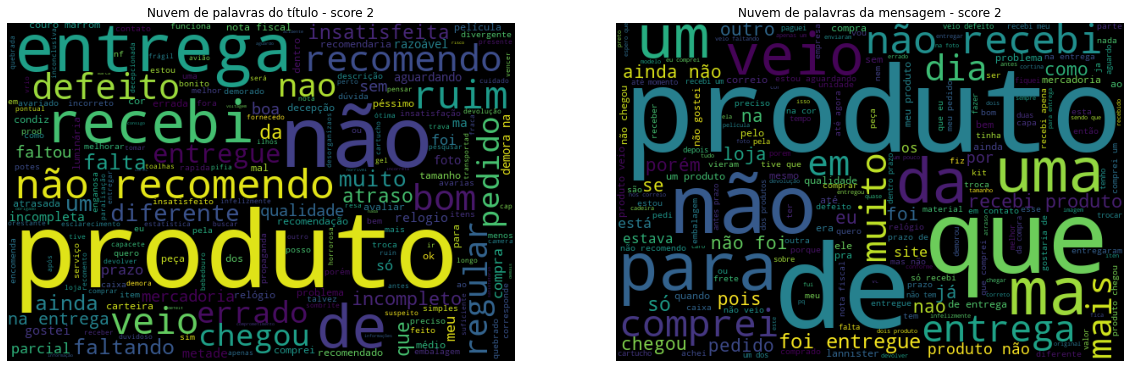

In [0]:
#obtém as nuvens de palavras do score 2
nuvem_title_5 = get_nuvem_title_by_score(2)
nuvem_msg_5 = get_nuvem_msg_by_score(2)
#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title_5)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 2")
axes[1].imshow(nuvem_msg_5)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 2")

Text(0.5, 1.0, 'Nuvem de palavras da mensagem - score 1')

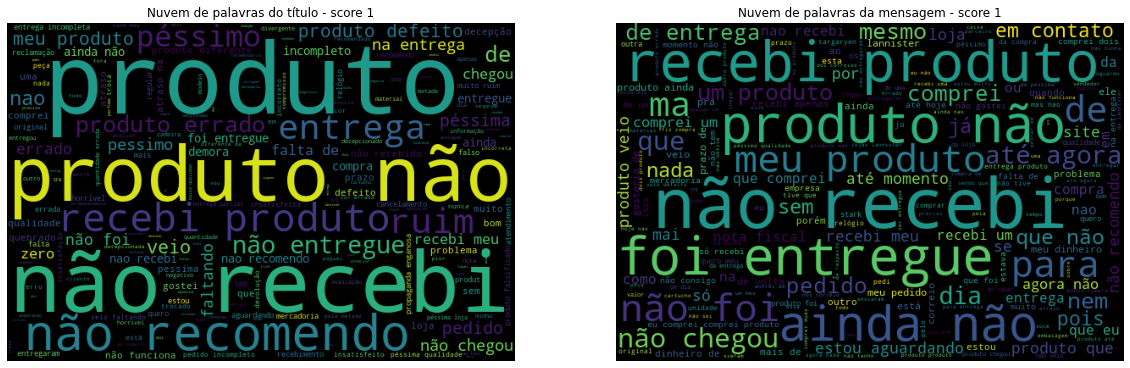

In [0]:
#obtém as nuvens de palavras do score 1
nuvem_title_5 = get_nuvem_title_by_score(1)
nuvem_msg_5 = get_nuvem_msg_by_score(1)
#imprime as nuvens de palavras
fig, axes = plt.subplots(ncols=2,figsize=(20,8))
axes[0].imshow(nuvem_title_5)
axes[0].axis('off')
axes[0].set_title("Nuvem de palavras do título - score 1")
axes[1].imshow(nuvem_msg_5)
axes[1].axis('off')
axes[1].set_title("Nuvem de palavras da mensagem - score 1")


# **Modelo de Machine Learning**: 

Vamos preparar nosso dataset para o processo

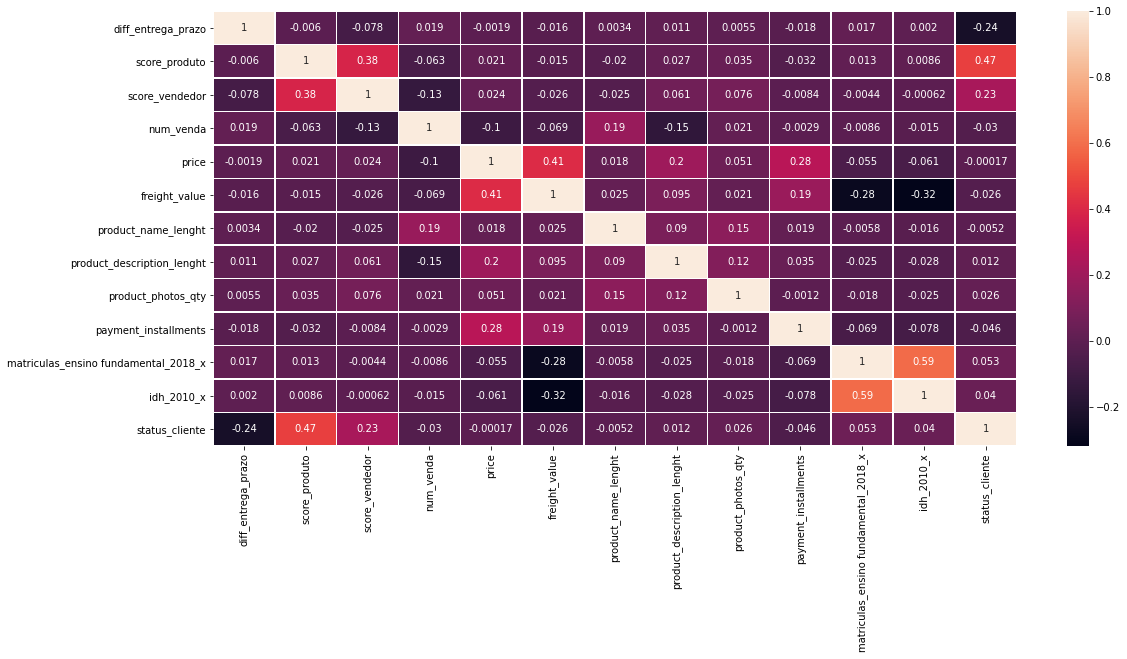

In [0]:
#a tabela paymentos é do tipo 1 para muitos, pois aceita um pedido pode ser pago com mais de 1 cartão de credito, vamos remover os dados duplicados para
pagamentos = payments.drop_duplicates(subset="order_id")

#com as avaliações ocorre o mesmo caso, as avaliações são realizadas para o pedido,não para os itens de cada pedido, no entanto, foi perdido que os clientes
#realizassem diversas avaliações para o mesmo medido. Vamos deixar apenas uma avaliação por pedido, geralmente as outras avaliações repetidas possuem o mesmo score
avaliacoes = reviews.drop_duplicates(subset="order_id")

#os pedidos realizados em 2016 parecem que tiveram diversos problems como observados dos diagramas de frequencia de avaliacao,então vamos remover os pedidos de 2016
df_basico_sem2016 = df_basico.loc[(pd.DatetimeIndex(df_basico["order_purchase_timestamp"]).year != 2016)]

#calcula o score dos vendedores com base no agrupamento das avaliações realizadas por vendedor
score_vendedor = dfb_reviews.groupby(["seller_id"]).agg(score_vendedor=("review_score", np.mean), num_venda=("order_id", "count"))

#calcula o score dos produtos, desconsidera os produtos não entregues e os que chegaram após o prazo
df_entregue_no_prazo = dfb_reviews.loc[(dfb_reviews["situacao_final"].eq("delivered") & (dfb_reviews["diff_entrega_prazo"].dt.days < 0))]
score_produto = df_entregue_no_prazo.groupby(["product_id"]).agg(score_produto=("review_score", np.mean))


#realiza a junção de todos os dataframes
df_final = pd.merge(df_basico_sem2016, avaliacoes, on="order_id",how="inner")
df_final = pd.merge(df_final, pagamentos, on="order_id",how="inner")
df_final = pd.merge(df_final, score_vendedor, on="seller_id",how="inner")
df_final = pd.merge(df_final, score_produto, on="product_id",how="inner")
df_final["diff_entrega_prazo"] = df_final["diff_entrega_prazo"].dt.days

#Vamos discretizar a coluna review_score agrupando os scores 1, 2 e 3 como insatisfeitos e os scores 4 e 5 como satisfeitos.
df_final['status_cliente'] = df_final['review_score'].apply(lambda x: 0 if x in [1,2] else 1)
#df_final['status_cliente'] = df_final['status_cliente'].apply(lambda x: 1 if x in [4,5] else x)
#df_final['status_cliente'] = df_final['status_cliente'].apply(lambda x: 0 if x == 3 else x)


#"price", "freight_value", "product_category_name","product_name_lenght", "product_description_lenght","product_photos_qty", "payment_installments", "situacao_final"

#seleciona apenas as colunas que serão utilizadas no modelo
colunas = ["diff_entrega_prazo", "score_produto","score_vendedor", "num_venda", "price", "freight_value", "product_category_name", "product_name_lenght", "product_description_lenght", "product_photos_qty", "payment_type", "payment_installments", "matriculas_ensino fundamental_2018_x", "idh_2010_x", "status_cliente"]
df_model  = df_final.loc[: , colunas]

#myModel = MyModelML(df_model, 'status_cliente')
#myModel.get_metrics()

correlation = df_model.corr()
plt.figure(figsize=(18,8))
sns.heatmap(correlation, annot=True, fmt=".2g", linewidths=0.5)

In [0]:
df_final["status_cliente"].unique()

array([ 1,  0, -1])

In [0]:
#Cria classe para o Aprendizado de Maquinas
class MyModelML():

  N_ESTIMATOR = 200
  RANDOM_STATE = 42
  TEST_SIZE = 0.2

  def __init__(self, df, col_y):  
    X, Y = self.separar_xy(df, col_y)
    X = self.tratamento(X)
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
              test_size=self.TEST_SIZE, random_state=self.RANDOM_STATE)
    self.Y_pred = self.train_rbf()
    
  def separar_xy(self, df, col_y):
    X = df.drop(columns=[col_y], axis=1) #remove a coluna Y
    Y = df.loc[:, col_y]                 #seleciona apenas a coluna Y
    return X, Y

  def tratamento(self, X):
    X  = self.categorizar(X)        #faz a categorização, colunas com 0 e 1
    X = self.normalizar(X)          #faz a normalização converte para 0 e 1
    return X

  # faz a discretização das variaveis categorias
  def categorizar(self, df):
    return pd.get_dummies(df)

  #faz a normalização dos dados para escala de 0 e 1
  def normalizar(self, df):
    scaler = MinMaxScaler() 
    matriz_01 = scaler.fit_transform(df)
    #transforma a resultado novamente em DataFrame
    return pd.DataFrame(matriz_01, columns = df.columns)

  #cria o modelo de machine learning: floresta aleatórias
  def train_rbf(self):
    self.rf = RandomForestClassifier(n_estimators=self.N_ESTIMATOR, 
                                     random_state= self.RANDOM_STATE )
    self.rf.fit(self.X_train, self.Y_train) #faz o treinamento
    self.Y_pred = self.rf.predict(self.X_test) #faz as predições
    return self.Y_pred

  def calcular_erro_medio(self):
    return mean_squared_error(self.Y_test, self.Y_pred)

  def get_matriz_confusao(self):
    return  confusion_matrix(self.Y_test, self.Y_pred)    
    
  def get_metrics(self):
    vn, fp, fn, vp = confusion_matrix(self.Y_test, self.Y_pred).ravel()
    acuracia = (vp+vn)/(vp+vn+fp+fn)
    precisao = vp / (vp+fp)
    revocacao = vp / (vp+fn)
    f1_score = ((2 * precisao) + revocacao) / (precisao + revocacao)
    return acuracia, precisao, revocacao, f1_score

  def print_metrics(self):    
    print(classification_report(self.Y_test, self.Y_pred, target_names=["Não Satisfeito", "Satisfeito"]))

  def get_feature_importances(self):
    return pd.Series(self.rf.feature_importances_, index=self.X_test.columns.tolist()
    ).sort_values(ascending=False).head(10)
    
  def get_predicts(self):
    return self.Y_pred


In [0]:
#cria um objeto da classe MyModelML, passando o dataframe com as colunas a serem utilizadas e a coluna de predição
myModel = MyModelML(df_model, 'status_cliente')

In [0]:
#imprime a matriz de Confusão
matriz_confusao = myModel.get_matriz_confusao()
pd.DataFrame(matriz_confusao, index=["NÃO", "SIM"], columns=["NÃO", "SIM"])    

NÃO    SIM
NÃO  2069   1255
SIM   551  17998

In [0]:
acuracia, precisao, revocacao, f1_score = myModel.get_metrics() 
print("Acurácia: {:.1f}".format(acuracia * 100))
print("Precisão: {:.1f}".format(precisao * 100))
print("Revocação: {:.1f}".format(revocacao * 100))
print("F1 Score: {:.1f}".format(f1_score * 100)) 

Acurácia: 91.7
Precisão: 93.5
Revocação: 97.0
F1 Score: 149.1


In [0]:
myModel.print_metrics()

                precision    recall  f1-score   support

Não Satisfeito       0.79      0.62      0.70      3324
    Satisfeito       0.93      0.97      0.95     18549

      accuracy                           0.92     21873
     macro avg       0.86      0.80      0.82     21873
  weighted avg       0.91      0.92      0.91     21873



In [0]:
#imprime a erro médio
myModel.calcular_erro_medio()

0.08256754903305445

Text(0.5, 1.0, 'Caracteristicas mais importantes')

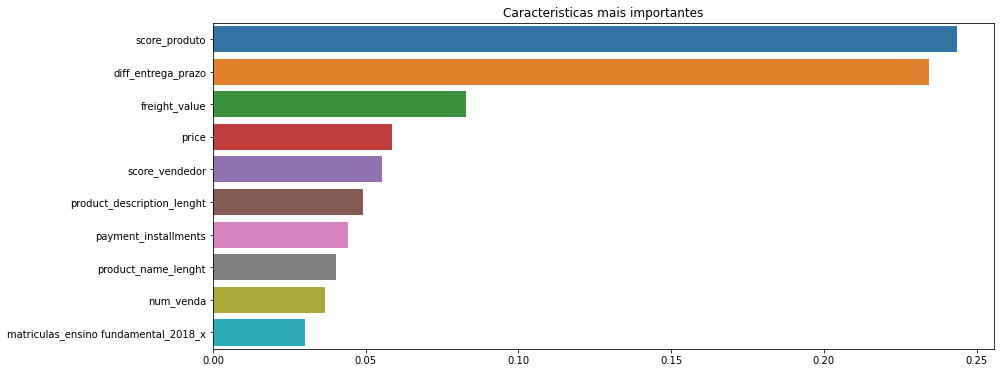

In [0]:
#imprime as principais caracteristicas do modelo
plt.figure(figsize=(14,6))
df = myModel.get_feature_importances()
sns.barplot(x=df.values, y=df.index).set_title("Caracteristicas mais importantes")

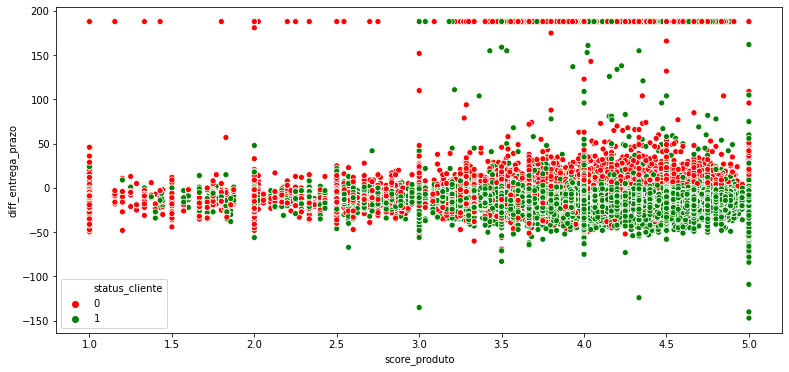

In [0]:
df_print = df_final.loc[:, ["score_produto","diff_entrega_prazo", "status_cliente"]]
plt.figure(figsize=(13,6))
sns.scatterplot(x="score_produto",y="diff_entrega_prazo",hue="status_cliente", data=df_final, palette=["red", "green"])